# Event-Based Portfolio Backtesting System

**Strategy:** Trend Following with Event-Driven Architecture  
**Universe:** S&P 500 (SPY) Constituent Stocks  
**Period:** January 2010 - December 2019  
**Initial Capital:** $500,000 USD  
**Transaction Cost:** 0%  
**Leverage:** 0x  

---

## 1. Setup and Imports

In [23]:
# Install required packages
%pip install pandas numpy yfinance matplotlib seaborn ta scipy tqdm -q ipywidgets


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator, ADXIndicator
from ta.volatility import AverageTrueRange, BollingerBands
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass, field
from enum import Enum
from datetime import datetime, timedelta
import warnings
from tqdm.notebook import tqdm
import json

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

print("✅ All imports successful!")

✅ All imports successful!


## 2. Configuration and Data Classes

In [62]:
@dataclass
class StrategyConfig:
    """Strategy configuration parameters"""
    # Technical indicator parameters
    ema_fast: int = 20
    ema_slow: int = 50
    rsi_period: int = 14
    adx_period: int = 14
    atr_period: int = 14
    
    # Bollinger Bands parameters
    bb_period: int = 20
    bb_std: float = 2.0
    
    adx_threshold: float = 25.0       # ADX trend strength threshold
    
    # Mean Reversion parameters
    mr_profit_target: float = 0.04  # 2% profit target
    mr_stop_loss: float = 0.01      # 1% stop loss
    
    # Regime parameters
    vix_low_threshold: float = 15.0
    vix_high_threshold: float = 20.0
    vix_smoothing_period: int = 5
    
    # Risk management
    stop_loss_pct: float = 0.02  # 2%
    trailing_stop_pct: float = 0.015  # 1.5%
    max_portfolio_drawdown: float = 0.15  # 15%
    risk_per_trade: float = 0.02 # 2%
    min_position_size: float = 0.3  # 10%
    max_position_size: float = 0.5  # 20% per stock (for portfolio)
    
    # Portfolio parameters
    initial_capital: float = 500000.0  # $500K
    transaction_cost: float = 0.0  # 0%
    leverage: float = 0.0  # No leverage
    max_positions: int = 10  # Max concurrent positions
    
    # Data parameters
    train_start: str = "2010-01-01"
    train_end: str = "2019-12-31"


class MarketRegime(Enum):
    """Market volatility regimes"""
    LOW_VOLATILITY = "low_vol"
    NORMAL_VOLATILITY = "normal_vol"
    HIGH_VOLATILITY = "high_vol"


class EventType(Enum):
    """Types of market events"""
    # Regime events
    REGIME_CHANGE = "regime_change"
    
    # Trend following events
    GOLDEN_CROSS = "golden_cross"
    DEATH_CROSS = "death_cross"
    ADX_STRONG_TREND = "adx_strong_trend"
    ADX_WEAK_TREND = "adx_weak_trend"
    
    # Mean reversion events
    BB_UPPER_CROSS = "bb_upper_cross"      # Price crosses above upper band
    BB_LOWER_CROSS = "bb_lower_cross"      # Price crosses below lower band
    BB_MIDDLE_CROSS_UP = "bb_middle_cross_up"    # Price crosses middle band upward
    BB_MIDDLE_CROSS_DOWN = "bb_middle_cross_down"  # Price crosses middle band downward
    BB_SQUEEZE = "bb_squeeze"              # Bands tighten (volatility decreases)
    BB_EXPANSION = "bb_expansion"          # Bands widen (volatility increases)
    
    # RSI events
    RSI_OVERBOUGHT = "rsi_overbought"
    RSI_OVERSOLD = "rsi_oversold"
    RSI_EXIT_OVERBOUGHT = "rsi_exit_overbought"
    RSI_EXIT_OVERSOLD = "rsi_exit_oversold"
    
    # Exit events
    STOP_LOSS_HIT = "stop_loss_hit"
    TRAILING_STOP_HIT = "trailing_stop_hit"
    MAX_DRAWDOWN_HIT = "max_drawdown_hit"
    PROFIT_TARGET_HIT = "profit_target_hit"
    ORDER_FILLED = "order_filled"


@dataclass
class Event:
    """Represents a market event"""
    timestamp: datetime
    event_type: EventType
    symbol: str
    data: Dict
    priority: int = 0
    
    def __repr__(self):
        return f"Event({self.timestamp.date()}, {self.symbol}, {self.event_type.value}, priority={self.priority})"


@dataclass
class Position:
    """Represents an open position"""
    symbol: str
    side: str  # 'LONG' or 'SHORT'
    entry_price: float
    entry_time: datetime
    shares: float
    stop_loss: float
    trailing_stop: float
    highest_price: float = 0.0
    lowest_price: float = float('inf')
    regime: MarketRegime = MarketRegime.NORMAL_VOLATILITY
    
    @property
    def value(self) -> float:
        """Current position value"""
        return self.shares * self.entry_price


@dataclass
class Trade:
    """Completed trade record"""
    symbol: str
    side: str
    entry_time: datetime
    exit_time: datetime
    entry_price: float
    exit_price: float
    shares: float
    pnl: float
    pnl_pct: float
    reason: str
    regime: MarketRegime


print("✅ Configuration and data classes defined!")

✅ Configuration and data classes defined!


## 3. Get SPY Constituent Stocks

In [63]:
def get_spy_stocks(top_n: int = 50) -> List[str]:
    """
    Get SPY constituent stocks
    For this example, we'll use the top 50 most liquid S&P 500 stocks
    """
    # Top 50 S&P 500 stocks by market cap (as of 2010-2019 period)
    spy_stocks = [
        'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'BRK.B', 'JNJ', 'JPM', 'V', 'PG', 'XOM',
        'BAC', 'MA', 'T', 'DIS', 'HD', 'INTC', 'VZ', 'PFE', 'MRK', 'CSCO',
        'KO', 'PEP', 'WFC', 'CMCSA', 'C', 'CVX', 'NFLX', 'ABT', 'ORCL', 'COST',
        'BA', 'MCD', 'IBM', 'UNH', 'PM', 'GE', 'HON', 'QCOM', 'AMGN', 'MDT',
        'UPS', 'BMY', 'SBUX', 'TXN', 'LOW', 'MMM', 'LMT', 'CAT', 'NKE', 'GS'
    ]
    return ['NVDA','AAPL', 'MSFT', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'GOOG', 'BRK-B']

# def load_vix_data(config: StrategyConfig) -> pd.DataFrame:
#     """
#     Load and process VIX data for regime detection
#     Returns DataFrame with VIX data and regime indicators
#     """
#     # Download VIX data
#     vix = yf.download("^VIX", 
#                       start=config.train_start,
#                       end=config.train_end,
#                       progress=False)
    
#     # Calculate smoothed VIX (simple moving average)
#     vix['VIX_MA'] = vix['Close'].rolling(window=config.vix_smoothing_period).mean()
    
#     # Define market regime
#     vix['Regime'] = 'NORMAL'
#     vix.loc[vix['VIX_MA'] <= config.vix_low_threshold, 'Regime'] = 'LOW_VOL'
#     vix.loc[vix['VIX_MA'] >= config.vix_high_threshold, 'Regime'] = 'HIGH_VOL'
    
#     # Drop NaN values from moving average calculation
#     vix = vix.dropna()
    
#     return vix

def load_vix_data(config: StrategyConfig) -> pd.DataFrame:
    """
    Load and process VIX data for regime detection
    Returns DataFrame with VIX data and regime indicators
    """
    # Download VIX data
    vix = yf.download("^VIX", 
                      start=config.train_start,
                      end=config.train_end,
                      progress=False)
    # --- START OF FIX ---
    # Strip timezone information to make it compatible with stock data
    vix.index = vix.index.tz_localize(None)
    # --- END OF FIX ---
    # --- START OF FIX ---
    # Ensure the index is unique. yfinance can sometimes return duplicates.
    if not vix.index.is_unique:
        print("⚠️ Warning: VIX data contains duplicate index dates. Keeping first entry for each date.")
        vix = vix[~vix.index.duplicated(keep='first')]
    # --- END OF FIX ---
        
    # Calculate smoothed VIX (simple moving average)
    vix['VIX_MA'] = vix['Close'].rolling(window=config.vix_smoothing_period).mean()
    
    # Define market regime
    vix['Regime'] = 'NORMAL'
    vix.loc[vix['VIX_MA'] <= config.vix_low_threshold, 'Regime'] = 'LOW_VOL'
    vix.loc[vix['VIX_MA'] >= config.vix_high_threshold, 'Regime'] = 'HIGH_VOL'
    
    # Drop NaN values from moving average calculation
    vix = vix.dropna()
    
    return vix

# Get stock universe
SPY_STOCKS = get_spy_stocks(50)
print(f"✅ Using {len(SPY_STOCKS)} SPY stocks:")
print(f"   {', '.join(SPY_STOCKS[:10])}...")

✅ Using 10 SPY stocks:
   NVDA, AAPL, MSFT, AMZN, META, AVGO, GOOGL, TSLA, GOOG, BRK-B...


## 4. Technical Indicators

In [64]:
def calculate_indicators(df: pd.DataFrame, config: StrategyConfig) -> pd.DataFrame:
    """Calculate technical indicators for a stock"""
    data = pd.DataFrame(index=df.index)
    data['Close'] = df['Close']
    data['High'] = df['High']
    data['Low'] = df['Low']
    data['Volume'] = df['Volume']
    
    # EMAs
    data['EMA_Fast'] = EMAIndicator(df['Close'], window=config.ema_fast, fillna=True).ema_indicator()
    data['EMA_Slow'] = EMAIndicator(df['Close'], window=config.ema_slow, fillna=True).ema_indicator()
    
    # RSI
    data['RSI'] = RSIIndicator(df['Close'], window=config.rsi_period, fillna=True).rsi()
    
    # ADX
    adx = ADXIndicator(df['High'], df['Low'], df['Close'], window=config.adx_period, fillna=True)
    data['ADX'] = adx.adx()
    
    # ATR
    atr = AverageTrueRange(df['High'], df['Low'], df['Close'], window=config.atr_period, fillna=True)
    data['ATR'] = atr.average_true_range()
    data['ATR_Pct'] = data['ATR'] / data['Close']
    
    # Bollinger Bands
    bb = BollingerBands(df['Close'], window=config.bb_period, window_dev=config.bb_std, fillna=True)
    data['BB_Upper'] = bb.bollinger_hband()
    data['BB_Lower'] = bb.bollinger_lband()
    data['BB_Middle'] = bb.bollinger_mavg()
    data['BB_Width'] = (data['BB_Upper'] - data['BB_Lower']) / data['BB_Middle']
    data['BB_Pct_B'] = (df['Close'] - data['BB_Lower']) / (data['BB_Upper'] - data['BB_Lower'])
    
    # Drop initial NaN rows
    max_window = max(config.ema_slow, config.adx_period, config.rsi_period, config.bb_period)
    data = data.iloc[max_window:]
    
    return data

print("✅ Technical indicators function defined!")

✅ Technical indicators function defined!


## 5. Event Detector

In [91]:
class EventDetector:
    """
    Detects market events from price data.
    
    This CORRECTED version detects ALL events (trend, MR, RSI)
    all the time. The PortfolioBacktester (the "brain") will
    then decide which events to act on based on the regime.
    """
    
    def __init__(self, config: StrategyConfig):
        self.config = config
        self.previous_state = {}
        
    def detect_trend_events(self, symbol: str, current_data: pd.Series, prev_data: pd.Series,
                          timestamp: datetime) -> List[Event]:
        """Detect trend following events"""
        events = []
        
        # CROSSOVER EVENTS
        if (current_data['EMA_Fast'] > current_data['EMA_Slow'] and 
            prev_data['EMA_Fast'] <= prev_data['EMA_Slow']):
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.GOLDEN_CROSS,
                symbol=symbol,
                data={'price': current_data['Close'], 'rsi': current_data['RSI'], 'adx': current_data['ADX']},
                priority=10
            ))
        
        if (current_data['EMA_Fast'] < current_data['EMA_Slow'] and 
            prev_data['EMA_Fast'] >= prev_data['EMA_Slow']):
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.DEATH_CROSS,
                symbol=symbol,
                data={'price': current_data['Close'], 'rsi': current_data['RSI'], 'adx': current_data['ADX']},
                priority=10
            ))
        
        # ADX EVENTS
        if current_data['ADX'] > self.config.adx_threshold and prev_data['ADX'] <= self.config.adx_threshold:
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.ADX_STRONG_TREND,
                symbol=symbol,
                data={'adx': current_data['ADX'], 'price': current_data['Close']},
                priority=6
            ))
            
        if current_data['ADX'] < self.config.adx_threshold and prev_data['ADX'] >= self.config.adx_threshold:
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.ADX_WEAK_TREND,
                symbol=symbol,
                data={'adx': current_data['ADX'], 'price': current_data['Close']},
                priority=6
            ))
        
        return events
    
    def detect_mean_reversion_events(self, symbol: str, current_data: pd.Series, prev_data: pd.Series,
                                   timestamp: datetime) -> List[Event]:
        """Detect mean reversion events"""
        events = []
        
        # Bollinger Band crosses
        if (current_data['Close'] > current_data['BB_Upper'] and 
            prev_data['Close'] <= prev_data['BB_Upper']):
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.BB_UPPER_CROSS,
                symbol=symbol,
                data={'price': current_data['Close'], 'bb_upper': current_data['BB_Upper'],
                      'bb_width': current_data['BB_Width']},
                priority=8
            ))
            
        if (current_data['Close'] < current_data['BB_Lower'] and 
            prev_data['Close'] >= prev_data['BB_Lower']):
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.BB_LOWER_CROSS,
                symbol=symbol,
                data={'price': current_data['Close'], 'bb_lower': current_data['BB_Lower'],
                      'bb_width': current_data['BB_Width']},
                priority=8
            ))
        
        # Middle band crosses (potential exits)
        if (current_data['Close'] > current_data['BB_Middle'] and 
            prev_data['Close'] <= prev_data['BB_Middle']):
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.BB_MIDDLE_CROSS_UP,
                symbol=symbol,
                data={'price': current_data['Close'], 'bb_middle': current_data['BB_Middle']},
                priority=7
            ))
            
        if (current_data['Close'] < current_data['BB_Middle'] and 
            prev_data['Close'] >= prev_data['BB_Middle']):
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.BB_MIDDLE_CROSS_DOWN,
                symbol=symbol,
                data={'price': current_data['Close'], 'bb_middle': current_data['BB_Middle']},
                priority=7
            ))
        
        # Volatility events
        current_width = current_data['BB_Width']
        prev_width = prev_data['BB_Width']
        
        # Detect squeeze (bands narrowing significantly)
        # We can move '0.8' to config later if we want to test it
        if current_width < prev_width * 0.8:
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.BB_SQUEEZE,
                symbol=symbol,
                data={'bb_width': current_width, 'price': current_data['Close']},
                priority=5
            ))
            
        # Detect expansion (bands widening significantly)
        if current_width > prev_width * 1.2:
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.BB_EXPANSION,
                symbol=symbol,
                data={'bb_width': current_width, 'price': current_data['Close']},
                priority=5
            ))
        
        return events
    
    def detect_regime_change(self, symbol: str, current_regime: MarketRegime, 
                           prev_regime: MarketRegime, timestamp: datetime) -> Optional[Event]:
        """Detect changes in market regime"""
        if current_regime != prev_regime:
            return Event(
                timestamp=timestamp,
                event_type=EventType.REGIME_CHANGE,
                symbol=symbol,
                data={'new_regime': current_regime.value, 'old_regime': prev_regime.value},
                priority=10  
            )
        return None
    
    # --- THIS IS THE CORRECTED FUNCTION ---
    def detect_events(self, symbol: str, current_data: pd.Series, prev_data: Optional[pd.Series],
                     current_regime: MarketRegime, prev_regime: MarketRegime) -> List[Event]:
        """
Detect all events for a symbol at current timestamp
        
        This corrected version detects ALL event types (Trend, MR, RSI)
        all the time. The 'brain' (PortfolioBacktester) will
        decide which ones to use based on the regime.
        """
        events = []
        
        if prev_data is None:
            return events
        
        timestamp = current_data.name
        
        # Check for regime change first
        regime_event = self.detect_regime_change(symbol, current_regime, prev_regime, timestamp)
        if regime_event:
            events.append(regime_event)
        
        # --- START OF FIX ---
        
        # 1. Detect trend events (always)
        events.extend(self.detect_trend_events(symbol, current_data, prev_data, timestamp))
        
        # 2. Detect mean reversion events (always)
        events.extend(self.detect_mean_reversion_events(symbol, current_data, prev_data, timestamp))
        
        # 3. Detect RSI events (always)
        # We can move '70' and '30' to config later
        if current_data['RSI'] > 70 and prev_data['RSI'] <= 70:
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.RSI_OVERBOUGHT,
                symbol=symbol,
                data={'rsi': current_data['RSI'], 'price': current_data['Close']},
                priority=7
            ))
        
        if current_data['RSI'] < 25 and prev_data['RSI'] >= 25:
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.RSI_OVERSOLD,
                symbol=symbol,
                data={'rsi': current_data['RSI'], 'price': current_data['Close']},
                priority=7
            ))
            
        # --- END OF FIX ---
        
        return events

print("✅ CORRECTED Event detector class defined!")

✅ CORRECTED Event detector class defined!


## 6. Portfolio Event-Driven Backtester

In [92]:
class PortfolioBacktester:
    """
    Event-driven portfolio backtester
    Tracks daily capital changes and generates performance metrics
    """
    
    def __init__(self, config: StrategyConfig, stock_data: Dict[str, pd.DataFrame], vix_data: pd.DataFrame):
        self.config = config
        self.stock_data = stock_data
        self.symbols = list(stock_data.keys())
        self.vix_data = vix_data
        
        # Portfolio state
        self.capital = config.initial_capital
        self.initial_capital = config.initial_capital
        self.positions: Dict[str, Position] = {}
        self.trades: List[Trade] = []
        self.event_log: List[Event] = []
        
        # Daily tracking
        self.daily_capital: List[Dict] = []
        self.daily_positions: List[Dict] = []
        self.current_regime = MarketRegime.NORMAL_VOLATILITY
        
        self.trading_dates = self.vix_data.index
        
        # Event detection
        self.event_detector = EventDetector(config)
        self.previous_data: Dict[str, pd.Series] = {}
    
    # def get_market_regime(self, date: datetime) -> MarketRegime:
    #     """Get the market regime for a given date based on VIX"""
    #     if date in self.vix_data.index:
    #         vix_value = self.vix_data.loc[date, 'VIX_MA']
    #         if vix_value <= self.config.vix_low_threshold:
    #             return MarketRegime.LOW_VOLATILITY
    #         elif vix_value >= self.config.vix_high_threshold:
    #             return MarketRegime.HIGH_VOLATILITY
    #         return MarketRegime.NORMAL_VOLATILITY
    #     return self.current_regime\
    def get_market_regime(self, date: datetime) -> MarketRegime:
        """Get the market regime for a given date based on VIX"""
        if date in self.vix_data.index:
            
            # --- START OF FIX ---
            # Get the VIX value. This might be a Series if there are duplicate dates.
            vix_value_or_series = self.vix_data.loc[date, 'VIX_MA']
            
            # If it's a Series (due to duplicate index), just take the first value.
            if isinstance(vix_value_or_series, pd.Series):
                vix_value = vix_value_or_series.iloc[0]
            else:
                vix_value = vix_value_or_series
            # --- END OF FIX ---
            
            # Now, vix_value is guaranteed to be a single number.
            if vix_value <= self.config.vix_low_threshold:
                return MarketRegime.LOW_VOLATILITY
            elif vix_value >= self.config.vix_high_threshold:
                return MarketRegime.HIGH_VOLATILITY
            return MarketRegime.NORMAL_VOLATILITY
        
        # If date is not in VIX data (e.g., holiday), use the last known regime
        return self.current_regime
    
    def calculate_position_size(self, symbol: str, price: float, atr_pct: float, regime: MarketRegime) -> float:
        """Calculate number of shares to buy based on risk and market regime"""
        # Base position size calculation
        available_capital = self.capital * self.config.max_position_size
        
        # Adjust risk based on regime
        regime_risk_multiplier = {
            MarketRegime.LOW_VOLATILITY: 1.2,    # More aggressive in low vol
            MarketRegime.NORMAL_VOLATILITY: 1.0,  # Normal risk
            MarketRegime.HIGH_VOLATILITY: 0.7     # More conservative in high vol
        }
        
        # Adjust position size based on regime
        regime_size_multiplier = {
            MarketRegime.LOW_VOLATILITY: 1.2,     # Larger positions in low vol
            MarketRegime.NORMAL_VOLATILITY: 1.0,   # Normal position size
            MarketRegime.HIGH_VOLATILITY: 0.8      # Smaller positions in high vol
        }
        
        # Calculate base risk-adjusted position size
        if atr_pct > 0:
            risk_multiplier = self.config.risk_per_trade / atr_pct
            risk_multiplier *= regime_risk_multiplier[regime]
            size_multiplier = min(risk_multiplier, self.config.max_position_size)
            size_multiplier = max(size_multiplier, self.config.min_position_size)
        else:
            size_multiplier = self.config.min_position_size
        
        # Apply regime-specific size adjustment
        size_multiplier *= regime_size_multiplier[regime]
        
        # Calculate final position size
        position_capital = available_capital * size_multiplier
        shares = position_capital / price
        
        # Apply leverage (currently 0)
        shares *= (1 + self.config.leverage)
        
        return shares
    
    def calculate_stop_levels(self, price: float, atr_pct: float, regime: MarketRegime) -> Tuple[float, float]:
        """Calculate stop loss and trailing stop levels based on regime"""
        # Adjust stop distances based on regime
        regime_stop_multiplier = {
            MarketRegime.LOW_VOLATILITY: 0.8,     # Tighter stops in low vol
            MarketRegime.NORMAL_VOLATILITY: 1.0,   # Normal stops
            MarketRegime.HIGH_VOLATILITY: 1.5      # Wider stops in high vol
        }
        
        # Calculate ATR-based stops
        stop_distance = max(atr_pct * 2, self.config.stop_loss_pct) * regime_stop_multiplier[regime]
        trailing_distance = max(atr_pct * 1.5, self.config.trailing_stop_pct) * regime_stop_multiplier[regime]
        
        stop_loss = price * (1 - stop_distance)
        trailing_stop = price * (1 - trailing_distance)
        
        return stop_loss, trailing_stop
    
    def open_position(self, symbol: str, price: float, timestamp: datetime, atr_pct: float):
        """Open a new position with regime-specific sizing"""
        # Get current regime
        current_regime = self.get_market_regime(timestamp)
        
        # Calculate position size based on regime
        shares = self.calculate_position_size(symbol, price, atr_pct, current_regime)
        position_cost = shares * price
        
        # Calculate stop levels based on regime
        stop_loss, trailing_stop = self.calculate_stop_levels(price, atr_pct, current_regime)
        
        # Apply transaction costs
        transaction_fee = position_cost * self.config.transaction_cost
        total_cost = position_cost + transaction_fee
        
        if total_cost > self.capital:
            return  # Not enough capital
        
        self.capital -= total_cost
        
        position = Position(
            symbol=symbol,
            side='LONG',
            entry_price=price,
            entry_time=timestamp,
            shares=shares,
            stop_loss=stop_loss,
            trailing_stop=trailing_stop,
            highest_price=price,
            regime=current_regime
        )
        
        self.positions[symbol] = position
    
    def can_open_position(self) -> bool:
        """Check if we can open a new position"""
        return len(self.positions) < self.config.max_positions
    
    def handle_mean_reversion_events(self, event: Event, current_data: pd.Series):
        """Handle mean reversion strategy events"""
        symbol = event.symbol
        
        # Entry conditions
        if event.event_type == EventType.BB_LOWER_CROSS and symbol not in self.positions:
            # Long entry when price crosses below lower band
            if (self.can_open_position() and 
                current_data['RSI'] < 30 and  # Confirm with RSI
                current_data['BB_Width'] > 0.025):  # Ensure bands aren't too tight
                self.open_position(symbol, event.data['price'], event.timestamp, current_data['ATR_Pct'])
        
        # Exit conditions for longs
        elif symbol in self.positions:
            position = self.positions[symbol]
            if position.side == 'LONG':
                # Take profit at middle band
                if event.event_type == EventType.BB_MIDDLE_CROSS_UP:
                    self.close_position(symbol, event.data['price'], event.timestamp, "Target Reached - Middle Band")
                # Exit if trend starts (regime change)
                elif event.event_type == EventType.ADX_STRONG_TREND:
                    self.close_position(symbol, event.data['price'], event.timestamp, "Exit - Strong Trend Detected")
    
    def handle_trend_following_events(self, event: Event, current_data: pd.Series):
        """Handle trend following strategy events"""
        symbol = event.symbol
        
        # Entry conditions
        if event.event_type == EventType.GOLDEN_CROSS and symbol not in self.positions:
            if (self.can_open_position() and 
                current_data['RSI'] > 50 and  # Confirm with RSI
                current_data['ADX'] > self.config.adx_threshold):  # Confirm trend strength
                self.open_position(symbol, event.data['price'], event.timestamp, current_data['ATR_Pct'])
        
        # Exit conditions
        elif symbol in self.positions:
            position = self.positions[symbol]
            if position.side == 'LONG':
                if event.event_type == EventType.DEATH_CROSS:
                    self.close_position(symbol, event.data['price'], event.timestamp, "Exit - Death Cross")
                elif event.event_type == EventType.ADX_WEAK_TREND:
                    self.close_position(symbol, event.data['price'], event.timestamp, "Exit - Weak Trend")
    
    def handle_regime_change(self, event: Event):
        """Handle regime change events"""
        new_regime = MarketRegime(event.data['new_regime'])
        old_regime = MarketRegime(event.data['old_regime'])
        
        # If switching from mean reversion to trend following (low/normal vol to high vol)
        if (old_regime in [MarketRegime.LOW_VOLATILITY, MarketRegime.NORMAL_VOLATILITY] and 
            new_regime == MarketRegime.HIGH_VOLATILITY):
            # Close mean reversion positions that don't align with trend
            for symbol, position in list(self.positions.items()):
                current_data = self.stock_data[symbol].loc[event.timestamp]
                if (current_data['EMA_Fast'] < current_data['EMA_Slow'] and position.side == 'LONG'):
                    self.close_position(symbol, current_data['Close'], event.timestamp, 
                                     "Regime Change - Closing Counter-Trend Position")
        
        # Update current regime
        self.current_regime = new_regime
    
    def check_profit_target(self, symbol: str, current_price: float, timestamp: datetime):
        """Check if profit target is hit for mean reversion trades"""
        if symbol not in self.positions:
            return
        
        position = self.positions[symbol]
        
        # Only check profit targets for mean reversion trades
        if position.regime in [MarketRegime.LOW_VOLATILITY, MarketRegime.NORMAL_VOLATILITY]:
            pnl_pct = (current_price - position.entry_price) / position.entry_price
            if pnl_pct >= self.config.mr_profit_target:
                self.close_position(symbol, current_price, timestamp, "Profit Target Hit")
    
    # def handle_event(self, event: Event):
    #     """Handle a market event"""
    #     self.event_log.append(event)
    #     symbol = event.symbol
        
    #     # Get current data for the symbol
    #     current_data = self.stock_data[symbol].loc[event.timestamp]
        
    #     # Handle regime changes first
    #     if event.event_type == EventType.REGIME_CHANGE:
    #         self.handle_regime_change(event)
    #         return
        
    #     # Apply regime-specific strategies
    #     if self.current_regime == MarketRegime.HIGH_VOLATILITY:
    #         # Use trend following in high volatility
    #         self.handle_trend_following_events(event, current_data)
    #     else:
    #         # Use mean reversion in low/normal volatility
    #         self.handle_mean_reversion_events(event, current_data)
    #         # Check profit targets for mean reversion trades
    #         self.check_profit_target(symbol, current_data['Close'], event.timestamp)
        
    #     # Always check stops regardless of regime
    #     self.check_stops(symbol, current_data['Close'], event.timestamp)
    def handle_event(self, event: Event):
        """Handle a market event"""
        self.event_log.append(event)
        
        # --- START OF FIX ---
        # Handle regime changes first, as they don't have a stock symbol
        if event.event_type == EventType.REGIME_CHANGE:
            self.handle_regime_change(event)
            return  # Stop here, no more processing needed for this event
        
        # All other events are stock-specific, so we can now safely get the symbol
        symbol = event.symbol
        
        # Get current data for the symbol
        # We must check if the date exists for this stock (e.g., late IPO)
        if event.timestamp not in self.stock_data[symbol].index:
            # print(f"Warning: No data for {symbol} on {event.timestamp}. Skipping event.")
            return
            
        current_data = self.stock_data[symbol].loc[event.timestamp]
        # --- END OF FIX ---

        # Apply regime-specific strategies
        if self.current_regime == MarketRegime.HIGH_VOLATILITY:
            # Use trend following in high volatility
            self.handle_trend_following_events(event, current_data)
        else:
            # Use mean reversion in low/normal volatility
            self.handle_mean_reversion_events(event, current_data)
            # # Check profit targets for mean reversion trades
            # self.check_profit_target(symbol, current_data['Close'], event.timestamp)
        
        # # Always check stops regardless of regime
        # self.check_stops(symbol, current_data['Close'], event.timestamp)

    def check_stops(self, symbol: str, current_price: float, timestamp: datetime):
        """Check if stops are hit for a position"""
        if symbol not in self.positions:
            return
        
        position = self.positions[symbol]
        
        # Update highest price and trailing stop
        if current_price > position.highest_price:
            position.highest_price = current_price
            # Use tighter trailing stops for mean reversion trades
            if position.regime in [MarketRegime.LOW_VOLATILITY, MarketRegime.NORMAL_VOLATILITY]:
                position.trailing_stop = current_price * (1 - self.config.trailing_stop_pct * 0.8)
            else:
                position.trailing_stop = current_price * (1 - self.config.trailing_stop_pct)
        
        # Check stop loss
        if current_price <= position.stop_loss:
            self.close_position(symbol, current_price, timestamp, "Stop Loss")
        # Check trailing stop
        elif current_price <= position.trailing_stop:
            self.close_position(symbol, current_price, timestamp, "Trailing Stop")
            
    # --- ADD THIS HELPER METHOD ---
    # (This was missing, but it's needed for daily value calculation in run())
    def calculate_portfolio_value(self, date: datetime) -> float:
        """Calculate total portfolio value (cash + open positions)"""
        market_value = 0.0
        for symbol, position in self.positions.items():
            if date in self.stock_data[symbol].index:
                current_price = self.stock_data[symbol].loc[date, 'Close']
                market_value += position.shares * current_price
            else:
                # Use last known price if market data is missing
                if symbol in self.previous_data:
                    market_value += position.shares * self.previous_data[symbol]['Close']
                else:
                    # Fallback if there's no previous data (e.g., data hole on first day)
                    market_value += position.shares * position.entry_price
        
        return self.capital + market_value

    # --- ADD THIS HELPER METHOD ---
    # (This was missing, but it's needed to record trades)
    def close_position(self, symbol: str, price: float, timestamp: datetime, reason: str):
        """Close an open position and record the trade"""
        if symbol not in self.positions:
            return
        
        position = self.positions.pop(symbol)
        
        # Calculate PnL
        pnl = (price - position.entry_price) * position.shares
        pnl_pct = (price - position.entry_price) / position.entry_price
        
        # Apply transaction costs
        transaction_fee = (price * position.shares) * self.config.transaction_cost
        total_pnl = pnl - transaction_fee
        
        # Add proceeds back to capital
        self.capital += (price * position.shares) - transaction_fee
        
        # Record the trade
        trade = Trade(
            symbol=symbol,
            side=position.side,
            entry_time=position.entry_time,
            exit_time=timestamp,
            entry_price=position.entry_price,
            exit_price=price,
            shares=position.shares,
            pnl=total_pnl,
            pnl_pct=pnl_pct,
            reason=reason,
            regime=position.regime
        )
        self.trades.append(trade)

        # Log event
        self.event_log.append(Event(
            timestamp=timestamp,
            event_type=EventType.ORDER_FILLED,
            symbol=symbol,
            data={'side': 'SELL', 'price': price, 'shares': position.shares, 'reason': reason},
            priority=100  # High priority to ensure it's processed
        ))
            
    def run(self):
        """Run the backtest"""
        print(f"\n{'='*60}")
        print("EVENT-DRIVEN PORTFOLIO BACKTEST")
        print(f"{'='*60}")
        print(f"Period: {self.config.train_start} to {self.config.train_end}")
        print(f"Universe: {len(self.symbols)} stocks")
        print(f"Initial Capital: ${self.initial_capital:,.0f}")
        print(f"{'='*60}\n")
        
        # Initialize previous regime
        prev_regime = self.get_market_regime(self.trading_dates[0])
        
        # Process each trading day
        for date in tqdm(self.trading_dates, desc="Processing days"):
            # Get current regime
            current_regime = self.get_market_regime(date)
            
            # Collect events for this day
            day_events = []
            
            # Check for regime change
            if current_regime != prev_regime:
                regime_event = Event(
                    timestamp=date,
                    event_type=EventType.REGIME_CHANGE,
                    symbol="MARKET",
                    data={'new_regime': current_regime.value, 'old_regime': prev_regime.value},
                    priority=10
                )
                day_events.append(regime_event)
            
            for symbol in self.symbols:
                if date not in self.stock_data[symbol].index:
                    continue
                
                current_data = self.stock_data[symbol].loc[date]
                prev_data = self.previous_data.get(symbol)
                
                # Detect events
                events = self.event_detector.detect_events(symbol, current_data, prev_data,
                                                        current_regime, prev_regime)
                day_events.extend(events)
                
                # Check stops and profit targets
                self.check_stops(symbol, current_data['Close'], date)
                self.check_profit_target(symbol, current_data['Close'], date)
                
                # Update previous data
                self.previous_data[symbol] = current_data
            
            # Sort events by priority
            day_events.sort(key=lambda e: e.priority, reverse=True)
            
            # Handle all events
            for event in day_events:
                self.handle_event(event)
            
            # Calculate daily portfolio value
            portfolio_value = self.calculate_portfolio_value(date)
            
            self.daily_capital.append({
                'date': date,
                'capital': self.capital,
                'portfolio_value': portfolio_value,
                'num_positions': len(self.positions),
                'invested': portfolio_value - self.capital,
                'regime': current_regime.value
            })
            
            # Update previous regime
            prev_regime = current_regime
        
        print(f"\n{'='*60}")
        print("BACKTEST COMPLETE")
        print(f"{'='*60}")
        print(f"Total Events: {len(self.event_log)}")
        print(f"Total Trades: {len(self.trades)}")
        final_value = self.daily_capital[-1]['portfolio_value']
        print(f"Final Portfolio Value: ${final_value:,.2f}")
        print(f"Total Return: {(final_value / self.initial_capital - 1) * 100:.2f}%")
        print(f"{'='*60}\n")

## 7. Performance Metrics Calculator

In [93]:
def calculate_portfolio_metrics(backtester: PortfolioBacktester) -> Dict:
    """Calculate comprehensive portfolio performance metrics"""
    
    # Convert to DataFrame
    df = pd.DataFrame(backtester.daily_capital)
    if df.empty:
        print("⚠️ No daily capital data found. Cannot calculate metrics.")
        return {}
    
    df.set_index('date', inplace=True)
    
    # Add regime information
    df['regime'] = df.index.map(lambda x: backtester.get_market_regime(x).value)
    
    # Calculate returns
    df['daily_return'] = df['portfolio_value'].pct_change().fillna(0)
    df['cumulative_return'] = (df['portfolio_value'] / backtester.initial_capital) - 1
    
    # Drawdown
    df['peak'] = df['portfolio_value'].cummax()
    df['drawdown'] = (df['portfolio_value'] - df['peak']) / df['peak']
    
    # --- Overall Metrics ---
    total_return = (df['portfolio_value'].iloc[-1] / backtester.initial_capital) - 1
    n_days = len(df)
    n_years = n_days / 252
    
    annualized_return = 0.0
    if n_years > 0:
        annualized_return = (1 + total_return) ** (1 / n_years) - 1
        
    daily_vol = df['daily_return'].std()
    annualized_vol = daily_vol * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0
    max_drawdown = df['drawdown'].min()
    
    # Downside risk for Sortino
    downside_returns = df[df['daily_return'] < 0]['daily_return']
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino_ratio = annualized_return / downside_std if downside_std > 0 else 0
    
    # Calmar Ratio
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0
    
    # --- Overall Trade Statistics ---
    trades_df = pd.DataFrame([{
        'symbol': t.symbol,
        'pnl': t.pnl,
        'pnl_pct': t.pnl_pct,
        'reason': t.reason,
        'regime': t.regime.value
    } for t in backtester.trades])
    
    total_trades = 0
    win_rate = 0.0
    profit_factor = 0.0
    avg_win_pct = 0.0
    avg_loss_pct = 0.0
    
    if len(trades_df) > 0:
        total_trades = len(trades_df)
        wins = trades_df[trades_df['pnl'] > 0]
        losses = trades_df[trades_df['pnl'] < 0]
        
        win_rate = len(wins) / total_trades if total_trades > 0 else 0.0
        avg_win_pct = wins['pnl_pct'].mean() if len(wins) > 0 else 0.0
        avg_loss_pct = losses['pnl_pct'].mean() if len(losses) > 0 else 0.0
        
        total_profit = wins['pnl'].sum()
        total_loss = abs(losses['pnl'].sum())
        profit_factor = total_profit / total_loss if total_loss > 0 else float('inf')

    
    # --- Regime-specific Performance ---
    regime_metrics = {}
    for regime in MarketRegime:
        regime_data = df[df['regime'] == regime.value]
        if len(regime_data) > 0:
            regime_return = regime_data['daily_return'].mean() * 252  # Annualized
            regime_vol = regime_data['daily_return'].std() * np.sqrt(252)
            regime_sharpe = regime_return / regime_vol if regime_vol > 0 else 0
            regime_drawdown = regime_data['drawdown'].min()
            
            regime_metrics[regime.value] = {
                'days': len(regime_data),
                'annualized_return': regime_return,
                'annualized_vol': regime_vol,
                'sharpe_ratio': regime_sharpe,
                'max_drawdown': regime_drawdown,
                'pct_time': len(regime_data) / len(df) * 100
            }
    
    # --- Regime-specific Trade Stats ---
    regime_trade_stats = {}
    if len(trades_df) > 0:
        for regime in MarketRegime:
            regime_trades = trades_df[trades_df['regime'] == regime.value]
            if len(regime_trades) > 0:
                r_win_rate = (regime_trades['pnl'] > 0).sum() / len(regime_trades)
                r_avg_win = regime_trades[regime_trades['pnl'] > 0]['pnl_pct'].mean() if (regime_trades['pnl'] > 0).any() else 0
                r_avg_loss = regime_trades[regime_trades['pnl'] < 0]['pnl_pct'].mean() if (regime_trades['pnl'] < 0).any() else 0
                r_profit_factor = abs(regime_trades[regime_trades['pnl'] > 0]['pnl'].sum() / 
                                 regime_trades[regime_trades['pnl'] < 0]['pnl'].sum()) if (regime_trades['pnl'] < 0).any() else float('inf')
                
                regime_trade_stats[regime.value] = {
                    'total_trades': len(regime_trades),
                    'win_rate': r_win_rate,
                    'avg_win': r_avg_win,
                    'avg_loss': r_avg_loss,
                    'profit_factor': r_profit_factor
                }
    
    # --- Compile final dictionary ---
    return {
        'overall': {
            'total_return': total_return,
            'annualized_return': annualized_return,
            'annualized_volatility': annualized_vol,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,  # <-- ADDED
            'calmar_ratio': calmar_ratio,    # <-- ADDED
            'max_drawdown': max_drawdown,
            'total_trades': total_trades,    # <-- ADDED
            'win_rate': win_rate,            # <-- ADDED
            'profit_factor': profit_factor,  # <-- ADDED
            'avg_win_pct': avg_win_pct,      # <-- ADDED
            'avg_loss_pct': avg_loss_pct,    # <-- ADDED
            'total_events': len(backtester.event_log),
            'final_value': df['portfolio_value'].iloc[-1]
        },
        'regime_metrics': regime_metrics,
        'regime_trade_stats': regime_trade_stats,
        'daily_data': df
    }

## 8. Visualization Functions

In [94]:
def plot_portfolio_performance(metrics: Dict):
    """Plot comprehensive portfolio performance"""
    
    df = metrics['daily_data']
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # 1. Portfolio Value
    axes[0].plot(df.index, df['portfolio_value'], label='Portfolio Value', color='green', linewidth=2)
    axes[0].axhline(y=df['portfolio_value'].iloc[0], color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
    axes[0].set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Portfolio Value ($)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    # 2. Drawdown
    axes[1].fill_between(df.index, 0, df['drawdown'] * 100, color='red', alpha=0.3)
    axes[1].axhline(y=-15, color='darkred', linestyle='--', linewidth=2, label='15% Kill Switch')
    axes[1].set_title('Portfolio Drawdown', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Drawdown (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. Number of Positions
    axes[2].plot(df.index, df['num_positions'], label='Active Positions', color='purple', linewidth=2)
    axes[2].fill_between(df.index, 0, df['num_positions'], alpha=0.3, color='purple')
    axes[2].set_title('Number of Active Positions', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Positions')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_performance_summary(metrics: Dict):
    """Print formatted performance summary"""
    
    if not metrics:
        print("No metrics to display.")
        return
        
    # --- FIX: Access metrics from the 'overall' dictionary ---
    overall = metrics['overall']
    
    print(f"\n{'='*60}")
    print("PORTFOLIO PERFORMANCE SUMMARY")
    print(f"{'='*60}\n")
    
    print("Returns:")
    print(f"  Total Return.................. {overall['total_return']*100:>10.2f}%")
    print(f"  Annualized Return............. {overall['annualized_return']*100:>10.2f}%")
    print(f"  Final Portfolio Value......... ${overall['final_value']:>10,.0f}")
    
    print(f"\nRisk Metrics:")
    print(f"  Annualized Volatility......... {overall['annualized_volatility']*100:>10.2f}%")
    print(f"  Maximum Drawdown.............. {overall['max_drawdown']*100:>10.2f}%")
    
    print(f"\nRisk-Adjusted Returns:")
    print(f"  Sharpe Ratio.................. {overall['sharpe_ratio']:>10.2f}")
    print(f"  Sortino Ratio................. {overall['sortino_ratio']:>10.2f}")
    print(f"  Calmar Ratio.................. {overall['calmar_ratio']:>10.2f}")
    
    print(f"\nTrading Statistics:")
    print(f"  Total Trades.................. {overall['total_trades']:>10}")
    print(f"  Total Events.................. {overall['total_events']:>10}")
    print(f"  Win Rate...................... {overall['win_rate']*100:>10.2f}%")
    print(f"  Profit Factor................. {overall['profit_factor']:>10.2f}")
    print(f"  Avg Win....................... {overall['avg_win_pct']*100:>10.2f}%")
    print(f"  Avg Loss...................... {overall['avg_loss_pct']*100:>10.2f}%")
    
    print(f"\n{'='*60}\n")

## 9. Main Backtest Function

In [95]:
def run_backtest(start_date: str, 
                 end_date: str, 
                 stock_list: List[str],
                 initial_capital: float = 500000.0,
                 transaction_cost: float = 0.0,
                 leverage: float = 0.0,
                 **other_params) -> Dict:
    """
    Run complete backtest on portfolio of stocks
    
    Args:
        start_date: Start date (YYYY-MM-DD)
        end_date: End date (YYYY-MM-DD)
        stock_list: List of stock symbols
        initial_capital: Starting capital
        transaction_cost: Transaction cost as decimal (0 = 0%)
        leverage: Leverage multiplier (0 = no leverage)
        **other_params: Additional strategy parameters
    
    Returns:
        Dictionary with results and metrics
    """
    
    print(f"\n{'='*60}")
    print("DOWNLOADING DATA")
    print(f"{'='*60}")
    print(f"Period: {start_date} to {end_date}")
    print(f"Stocks: {len(stock_list)} symbols")
    
    # Download data for all stocks
    stock_data = {}
    config = StrategyConfig(
        train_start=start_date,
        train_end=end_date,
        initial_capital=initial_capital,
        transaction_cost=transaction_cost,
        leverage=leverage,
        **other_params
    )
    
    for symbol in tqdm(stock_list, desc="Downloading"):
        try:
            ticker = yf.Ticker(symbol)
            df = ticker.history(start=start_date, end=end_date)
            df.columns = df.columns.get_level_values(0)
            # --- START OF FIX ---
            # Strip timezone information to make it compatible with VIX data
            df.index = df.index.tz_localize(None)
            # --- END OF FIX ---
            
            if len(df) < 100:  # Skip if insufficient data
                continue
            
            # Calculate indicators
            df_with_indicators = calculate_indicators(df, config)
            stock_data[symbol] = df_with_indicators
            
        except Exception as e:
            print(f"  ⚠️  Failed to download {symbol}: {e}")
            continue
        
    vix_data = load_vix_data(config)
    print("\n" + "="*40)
    print("--- DEBUG: VIX DATA & REGIMES ---")
    print(vix_data[['VIX_MA', 'Regime']].tail())
    print("\nRegime Counts:")
    print(vix_data['Regime'].value_counts(normalize=True) * 100)
    print("="*40)
    
    print("\n" + "="*40)
    print("--- DEBUG: SAMPLE STOCK DATA (AAPL) ---")
    if 'AAPL' in stock_data:
        # Print the last 5 rows of AAPL's indicator data
        print(stock_data['AAPL'].tail())
    else:
        print("AAPL data not found, printing first available stock.")
        first_stock = list(stock_data.keys())[0]
        print(stock_data[first_stock].tail())
    print("="*40 + "\n")
    # --- END OF DEBUGGING (STEP 1) ---
    
    print(f"\n✅ Successfully loaded {len(stock_data)} stocks\n")
    
    # Run backtest
    backtester = PortfolioBacktester(config, stock_data, vix_data)
    backtester.run()
    
    # --- START OF DEBUGGING (STEP 2) ---
    print("\n" + "="*40)
    print("--- DEBUG: EVENT LOG SUMMARY ---")
    from collections import Counter
    event_counts = Counter(e.event_type.value for e in backtester.event_log)
    
    if not event_counts:
        print("⚠️ CRITICAL: No events were generated at all!")
    else:
        print("Total events generated during backtest:")
        for event_type, count in event_counts.most_common():
            # Pad the event type string to align the counts
            print(f"  {event_type:<25} {count}")
    print("="*40 + "\n")
    # --- END OF DEBUGGING (STEP 2) ---
    # Calculate metrics
    metrics = calculate_portfolio_metrics(backtester)
    
    # Visualize
    plot_portfolio_performance(metrics)
    print_performance_summary(metrics)
    
    return {
        'metrics': metrics,
        'backtester': backtester,
        'config': config,
        'daily_capital': backtester.daily_capital,
        'trades': backtester.trades
    }

print("✅ Main backtest function defined!")

✅ Main backtest function defined!


In [96]:
import itertools

def download_raw_stock_data(stock_list: List[str], start_date: str, end_date: str) -> Dict[str, pd.DataFrame]:
    """
    Downloads and caches raw stock data (Open, High, Low, Close, Volume)
    without any indicators.
    """
    print(f"\n{'='*60}")
    print("DOWNLOADING RAW STOCK DATA")
    print(f"{'='*60}")
    
    raw_stock_data = {}
    
    for symbol in tqdm(stock_list, desc="Downloading Raw Data"):
        try:
            ticker = yf.Ticker(symbol)
            df = ticker.history(start=start_date, end=end_date)
            df.columns = df.columns.get_level_values(0)
            
            # 1. Strip timezone
            df.index = df.index.tz_localize(None)
            
            # 2. Get base columns
            df.columns = df.columns.get_level_values(0)
            df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
            
            if len(df) < 100:  # Skip if insufficient data
                continue
                
            raw_stock_data[symbol] = df
            
        except Exception as e:
            print(f"  ⚠️  Failed to download {symbol}: {e}")
            continue
    
    print(f"\n✅ Successfully loaded raw data for {len(raw_stock_data)} stocks\n")
    return raw_stock_data
import itertools

def run_parameter_grid_search(raw_stock_data: Dict[str, pd.DataFrame], 
                              vix_data: pd.DataFrame, 
                              base_config_dict: Dict,
                              param_grid: Dict) -> pd.DataFrame:
    """
    Runs a "Grid Search" to test every combination of parameters.
    
    This is the CORRECT (but slower) version that recalculates
    indicators for every single parameter set.
    
    Args:
        raw_stock_data: Dictionary of *raw* stock data (no indicators).
        vix_data: Your VIX data.
        base_config_dict: Your 'other_variables' dictionary.
        param_grid: A dictionary defining the parameters to test.
    """
    print(f"\n{'='*60}")
    print("STARTING CORRECTED PARAMETER GRID SEARCH")
    print(f"(This will be slow as it recalculates indicators...)")
    print(f"{'='*60}\n")
    
    # 1. Get all combinations from the grid
    keys, value_lists = zip(*param_grid.items())
    all_combinations = [dict(zip(keys, combo)) for combo in itertools.product(*value_lists)]
    
    total_runs = len(all_combinations)
    print(f"Total combinations to test: {total_runs}")
    
    results_log = []

    # 2. Loop through each combination
    for i, params_to_test in enumerate(tqdm(all_combinations, desc="Grid Search")):
        
        # Create a copy of the base config and update it
        current_config_dict = base_config_dict.copy()
        current_config_dict.update(params_to_test)
        
        try:
            # 3. Create the new config object
            test_config = StrategyConfig(**current_config_dict)
            
            # Simple check
            if test_config.ema_fast >= test_config.ema_slow:
                continue

            # 4. --- THIS IS THE NEW, CRITICAL STEP ---
            # Recalculate all indicators for this specific config
            stock_data_with_indicators = {}
            for symbol, raw_df in raw_stock_data.items():
                # Make sure raw_df is not modified in place
                df_with_indicators = calculate_indicators(raw_df.copy(), test_config)
                stock_data_with_indicators[symbol] = df_with_indicators

            # 5. Run the backtest with the newly calculated data
            backtester = PortfolioBacktester(test_config, stock_data_with_indicators, vix_data)
            
            # Suppress the backtester's own print statements
            # You can comment out the next line if you want to see the full output
            backtester.run() 
            
            metrics = calculate_portfolio_metrics(backtester)
            
            if 'overall' not in metrics:
                continue
            
            # 6. Store the results
            run_result = {
                'sharpe': metrics['overall']['sharpe_ratio'],
                'return': metrics['overall']['annualized_return'],
                'drawdown': metrics['overall']['max_drawdown'],
                'trades': metrics['overall']['total_trades']
            }
            # Add the parameters that were tested
            run_result.update(params_to_test)
            
            results_log.append(run_result)

        except Exception as e:
            print(f"Test {i+1} failed with params {params_to_test}: {e}")

    # 7. Return a DataFrame for easy analysis
    results_df = pd.DataFrame(results_log)
    
    print(f"\n{'='*60}")
    print("GRID SEARCH COMPLETE")
    print(f"{'='*60}\n")
    
    # Show the best results
    print("--- Top 10 Results by Sharpe Ratio ---")
    print(results_df.sort_values(by='sharpe', ascending=False).head(10))
    
    return results_df

## 10. FINAL NOTEBOOK CELL
---


DOWNLOADING DATA
Period: 2010-01-01 to 2019-12-31
Stocks: 10 symbols


Downloading:   0%|          | 0/10 [00:00<?, ?it/s]


--- DEBUG: VIX DATA & REGIMES ---
Price       VIX_MA   Regime
Ticker                     
Date                       
2019-12-23  12.498  LOW_VOL
2019-12-24  12.574  LOW_VOL
2019-12-26  12.588  LOW_VOL
2019-12-27  12.774  LOW_VOL
2019-12-30  13.236  LOW_VOL

Regime Counts:
Regime
LOW_VOL     45.479888
NORMAL      35.244922
HIGH_VOL    19.275189
Name: proportion, dtype: float64

--- DEBUG: SAMPLE STOCK DATA (AAPL) ---
                Close       High        Low     Volume   EMA_Fast   EMA_Slow  \
Date                                                                           
2019-12-23  68.589783  68.650161  67.713088   98572000  65.794237  62.650598   
2019-12-24  68.654968  68.804713  68.328931   48478800  66.066688  62.886063   
2019-12-26  70.017113  70.034020  68.758831   93121200  66.442919  63.165712   
2019-12-27  69.990547  70.997661  69.584807  146266000  66.780788  63.433353   
2019-12-30  70.405960  70.688534  68.884429  144114400  67.126043  63.706788   

                 

Processing days:   0%|          | 0/2511 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 8652
Total Trades: 50
Final Portfolio Value: $520,520.12
Total Return: 4.10%


--- DEBUG: EVENT LOG SUMMARY ---
Total events generated during backtest:
  regime_change             1442
  bb_middle_cross_down      1387
  bb_middle_cross_up        1385
  bb_upper_cross            843
  bb_expansion              674
  bb_lower_cross            584
  rsi_overbought            579
  adx_strong_trend          414
  adx_weak_trend            414
  bb_squeeze                370
  golden_cross              232
  death_cross               226
  rsi_oversold              52
  order_filled              50



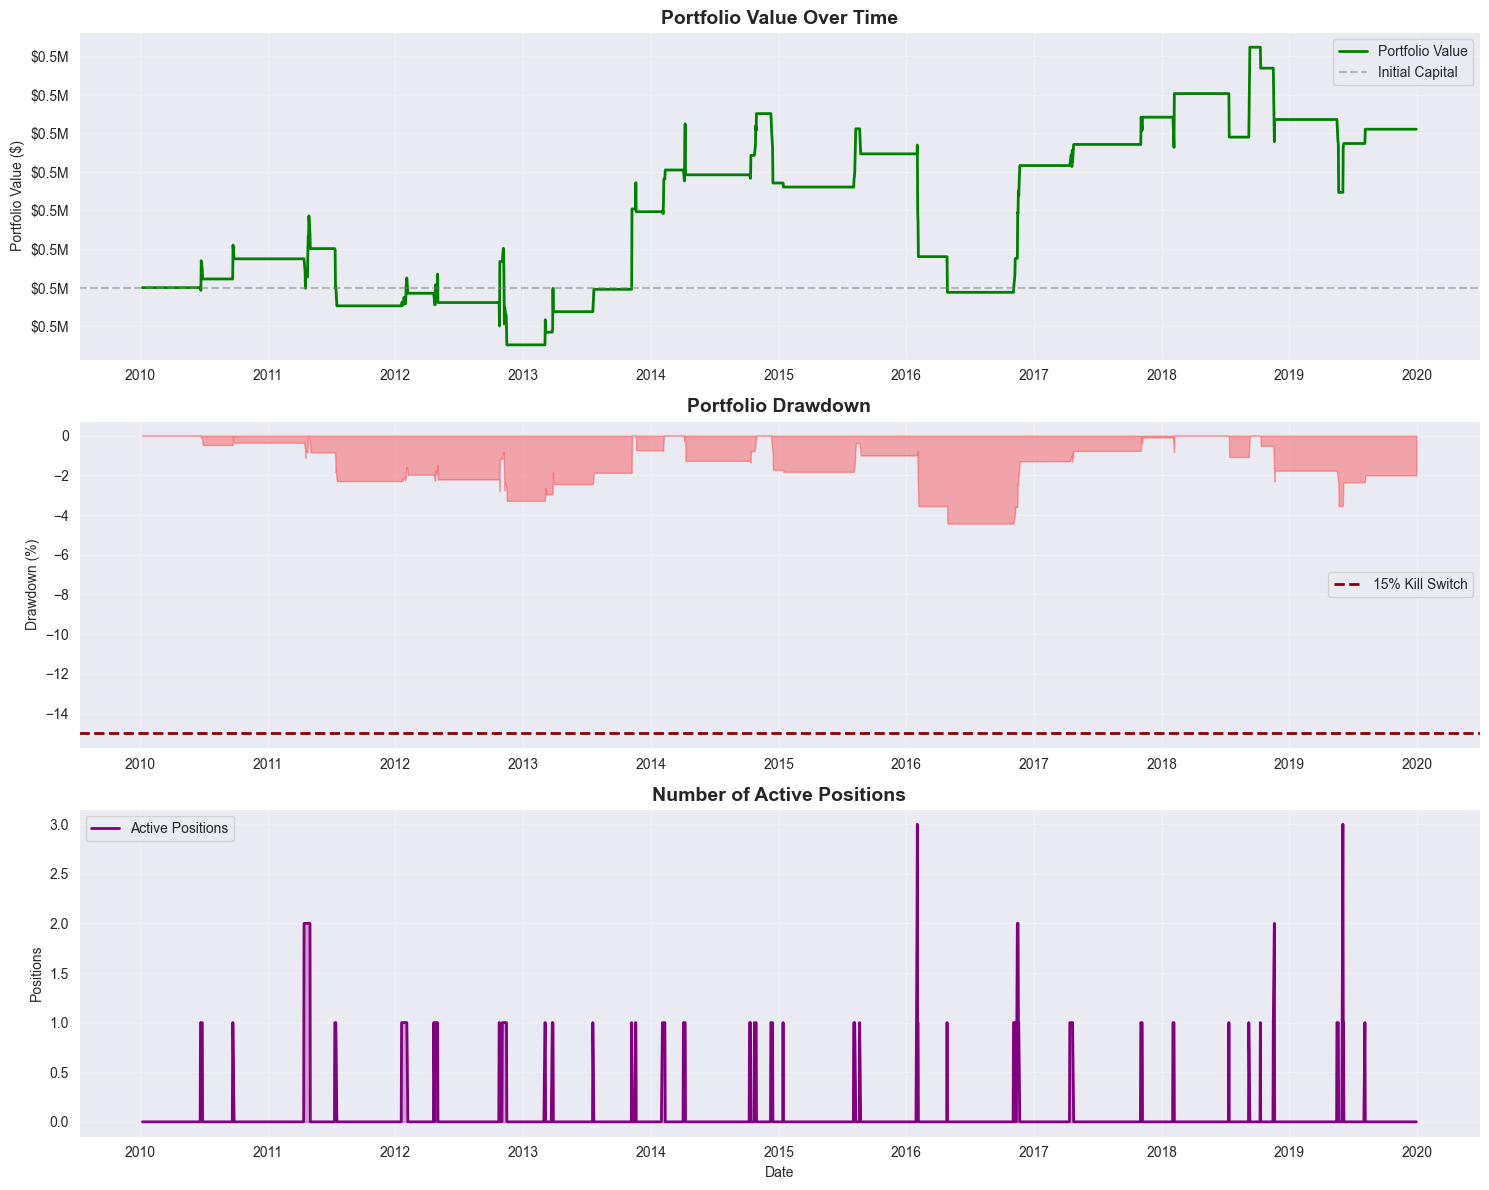


PORTFOLIO PERFORMANCE SUMMARY

Returns:
  Total Return..................       4.10%
  Annualized Return.............       0.40%
  Final Portfolio Value......... $   520,520

Risk Metrics:
  Annualized Volatility.........       2.24%
  Maximum Drawdown..............      -4.43%

Risk-Adjusted Returns:
  Sharpe Ratio..................       0.18
  Sortino Ratio.................       0.06
  Calmar Ratio..................       0.09

Trading Statistics:
  Total Trades..................         50
  Total Events..................       8652
  Win Rate......................      54.00%
  Profit Factor.................       1.25
  Avg Win.......................       2.97%
  Avg Loss......................      -3.97%


{'metrics': {'overall': {'total_return': np.float64(0.04104024056482891), 'annualized_return': np.float64(0.004044617865024858), 'annualized_volatility': np.float64(0.02238549085456175), 'sharpe_ratio': np.float64(0.1806803295626926), 'sortino_ratio': np.float64(0.06252324

In [97]:
# ============================================================================
# FINAL NOTEBOOK CELL
# ============================================================================

# Define parameters for the backtest
start_date = "2010-01-01"  # We will change this
end_date = "2019-12-31"    # We will change this
stock_list = SPY_STOCKS    # We will also change this

# Other parameters
other_variables = {
    'initial_capital': 500000.0,
    'transaction_cost': 0.0,
    'leverage': 0.0,
    'max_positions': 10,
    'max_position_size': 0.5,
    'stop_loss_pct': 0.05,
    'trailing_stop_pct': 0.015,
    'max_portfolio_drawdown': 0.15,
    'risk_per_trade': 0.02
}

# One function that runs the backtest
results = run_backtest(start_date=start_date, 
                       end_date=end_date,
                       stock_list=stock_list,
                       **other_variables)

# Display Results
print(results)

In [98]:
# # 1. Get the RAW data *once*
# # (This assumes 'stock_list', 'start_date', 'end_date' are defined)
# raw_data_cache = download_raw_stock_data(stock_list, start_date, end_date)

# # 2. Define the grid of parameters you want to "tweak"
# param_grid_to_test = {
#     # --- Trend Following Params ---
#     'ema_fast': [10, 20],
#     'ema_slow': [50],
#     'adx_threshold': [20, 25],
#     'adx_period': [14, 20],

#     # --- Mean Reversion Params ---
#     'bb_period': [20, 30],
#     'bb_std': [2.0, 2.5],
#     'rsi_period': [10, 14],
    
#     # --- Regime Params ---
#     'vix_low_threshold': [15],
#     'vix_high_threshold': [20, 25, 30]
# }

# # 3. Calculate and print total combinations
# total_combinations = 1
# for key in param_grid_to_test:
#     total_combinations *= len(param_grid_to_test[key])
# print(f"--- Starting Grid Search ---")
# print(f"Total combinations to test: {total_combinations}") # This will be 2*1*2*2 * 2*2*2 * 2*2 = 512 runs


# # 4. Get the other variables from your main backtest run
# if 'results' in locals():
#     # We only need the VIX data from the main run
#     base_vix_data = results['backtester'].vix_data
    
#     # 5. Run the NEW grid search function
#     grid_search_results = run_parameter_grid_search(
#         raw_stock_data=raw_data_cache,    # <-- Use the new raw data
#         vix_data=base_vix_data,
#         base_config_dict=other_variables, # Your dict from the main run
#         param_grid=param_grid_to_test
#     )
    
#     # 6. (Optional) Show results sorted by Drawdown
#     print("\n\n--- Top 10 Results by Lowest Max Drawdown ---")
#     print(grid_search_results.sort_values(by='drawdown', ascending=False).head(10))

# else:
#     print("❌ Please run the main 'run_backtest()' cell first to create the 'results' variable!")

In [99]:
# ============================================================================
# BUY-AND-HOLD BENCHMARK CALCULATOR
# ============================================================================

def calculate_buy_and_hold(stock_list: List[str], 
                          start_date: str, 
                          end_date: str, 
                          initial_capital: float = 500000.0) -> Dict:
    """
    Calculate buy-and-hold returns for equal-weighted portfolio
    
    Strategy: Buy equal amounts of all stocks at start, hold until end
    """
    print(f"\n{'='*60}")
    print("CALCULATING BUY-AND-HOLD BENCHMARK")
    print(f"{'='*60}")
    
    portfolio_data = []
    
    # Download data for all stocks
    for symbol in tqdm(stock_list, desc="Downloading B&H data"):
        try:
            ticker = yf.Ticker(symbol)
            df = ticker.history(start=start_date, end=end_date)
            
            if len(df) < 100:
                continue
            
            portfolio_data.append({
                'symbol': symbol,
                'start_price': df['Close'].iloc[0],
                'end_price': df['Close'].iloc[-1],
                'data': df
            })
            
        except Exception as e:
            continue
    
    # Equal weight allocation
    capital_per_stock = initial_capital / len(portfolio_data)
    
    # Calculate daily portfolio values
    total_value = 0
    daily_values = {}
    
    for stock in portfolio_data:
        shares = capital_per_stock / stock['start_price']
        final_value = shares * stock['end_price']
        total_value += final_value
        
        # Track daily values
        for date, row in stock['data'].iterrows():
            if date not in daily_values:
                daily_values[date] = 0
            daily_values[date] += shares * row['Close']
    
    # Create daily portfolio dataframe
    df_daily = pd.DataFrame([
        {'date': date, 'portfolio_value': value}
        for date, value in sorted(daily_values.items())
    ])
    df_daily.set_index('date', inplace=True)
    
    # Calculate returns
    df_daily['daily_return'] = df_daily['portfolio_value'].pct_change()
    df_daily['cumulative_return'] = (df_daily['portfolio_value'] / initial_capital) - 1
    
    # Drawdown
    df_daily['peak'] = df_daily['portfolio_value'].cummax()
    df_daily['drawdown'] = (df_daily['portfolio_value'] - df_daily['peak']) / df_daily['peak']
    
    # Performance metrics
    total_return = (total_value / initial_capital) - 1
    n_days = len(df_daily)
    n_years = n_days / 252
    annualized_return = (1 + total_return) ** (1 / n_years) - 1
    
    daily_vol = df_daily['daily_return'].std()
    annualized_vol = daily_vol * np.sqrt(252)
    
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0
    
    downside_returns = df_daily['daily_return'][df_daily['daily_return'] < 0]
    downside_std = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0.0001
    sortino_ratio = annualized_return / downside_std if downside_std > 0 else 0
    
    max_drawdown = df_daily['drawdown'].min()
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    print(f"\n✅ Buy-and-Hold calculated for {len(portfolio_data)} stocks")
    print(f"Final Value: ${total_value:,.2f}")
    print(f"Total Return: {total_return*100:.2f}%")
    
    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_vol,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio,
        'final_value': total_value,
        'daily_data': df_daily,
        'num_stocks': len(portfolio_data)
    }

print("✅ Buy-and-Hold benchmark function defined!")

✅ Buy-and-Hold benchmark function defined!


In [100]:
def compare_strategy_vs_benchmark(strategy_metrics: Dict, 
                                  bh_metrics: Dict,
                                  start_date: str,
                                  end_date: str):
    """
    Compare strategy performance vs buy-and-hold benchmark
    """
    
    # Extract data
    strategy_data = strategy_metrics['daily_data']
    bh_data = bh_metrics['daily_data']
    
    # Create comparison plots
    fig, axes = plt.subplots(3, 2, figsize=(18, 14))
    
    # 1. Portfolio Value Comparison
    axes[0, 0].plot(strategy_data.index, strategy_data['portfolio_value'], 
                    label='Strategy', color='green', linewidth=2)
    axes[0, 0].plot(bh_data.index, bh_data['portfolio_value'], 
                    label='Buy & Hold', color='blue', linewidth=2, alpha=0.7)
    
    # FIX: Access strategy_metrics['overall'] but bh_metrics directly
    axes[0, 0].axhline(y=strategy_metrics['overall']['final_value'], color='green', 
                       linestyle='--', alpha=0.3)
    axes[0, 0].axhline(y=bh_metrics['final_value'], color='blue',  # <-- FIXED
                       linestyle='--', alpha=0.3)
    
    axes[0, 0].set_title('Portfolio Value: Strategy vs Buy-and-Hold', 
                         fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Portfolio Value ($)')
    axes[0, 0].legend(loc='best')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    # ... (Plots 0,1 and 1,0 and 1,1 are fine as they only use 'daily_data') ...
    
    # 4. Rolling Sharpe Ratio (252-day window)
    strategy_rolling_sharpe = (strategy_data['daily_return'].rolling(252).mean() * 252) / \
                              (strategy_data['daily_return'].rolling(252).std() * np.sqrt(252))
    bh_rolling_sharpe = (bh_data['daily_return'].rolling(252).mean() * 252) / \
                        (bh_data['daily_return'].rolling(252).std() * np.sqrt(252))
    
    axes[1, 1].plot(strategy_data.index, strategy_rolling_sharpe, 
                    label='Strategy', color='green', linewidth=2)
    axes[1, 1].plot(bh_data.index, bh_rolling_sharpe, 
                    label='Buy & Hold', color='blue', linewidth=2, alpha=0.7)
    axes[1, 1].axhline(y=1.0, color='red', linestyle='--', linewidth=1, label='Sharpe = 1.0')
    axes[1, 1].set_title('Rolling Sharpe Ratio (1-Year)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Sharpe Ratio')
    axes[1, 1].legend(loc='best')
    axes[1, 1].grid(True, alpha=0.3)
    
    
    # 5. Performance Metrics Bar Chart
    # FIX: Access strategy_metrics['overall'] but bh_metrics directly
    metrics_comparison = {
        'Total Return (%)': [strategy_metrics['overall']['total_return'] * 100, 
                            bh_metrics['total_return'] * 100], # <-- FIXED
        'Ann. Return (%)': [strategy_metrics['overall']['annualized_return'] * 100, 
                           bh_metrics['annualized_return'] * 100], # <-- FIXED
        'Sharpe Ratio': [strategy_metrics['overall']['sharpe_ratio'], 
                        bh_metrics['sharpe_ratio']], # <-- FIXED
        'Sortino Ratio': [strategy_metrics['overall']['sortino_ratio'], 
                         bh_metrics['sortino_ratio']], # <-- FIXED
        'Calmar Ratio': [strategy_metrics['overall']['calmar_ratio'], 
                        bh_metrics['calmar_ratio']] # <-- FIXED
    }
    
    x = np.arange(len(metrics_comparison))
    width = 0.35
    
    strategy_values = [v[0] for v in metrics_comparison.values()]
    bh_values = [v[1] for v in metrics_comparison.values()]
    
    axes[2, 0].bar(x - width/2, strategy_values, width, label='Strategy', color='green', alpha=0.7)
    axes[2, 0].bar(x + width/2, bh_values, width, label='Buy & Hold', color='blue', alpha=0.7)
    axes[2, 0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
    axes[2, 0].set_ylabel('Value')
    axes[2, 0].set_xticks(x)
    axes[2, 0].set_xticklabels(metrics_comparison.keys(), rotation=45, ha='right')
    axes[2, 0].legend(loc='best')
    axes[2, 0].grid(True, alpha=0.3, axis='y')
    axes[2, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # 6. Risk Metrics Bar Chart
    # FIX: Access strategy_metrics['overall'] but bh_metrics directly
    risk_comparison = {
        'Ann. Vol (%)': [strategy_metrics['overall']['annualized_volatility'] * 100, 
                        bh_metrics['annualized_volatility'] * 100], # <-- FIXED
        'Max DD (%)': [strategy_metrics['overall']['max_drawdown'] * 100, 
                      bh_metrics['max_drawdown'] * 100] # <-- FIXED
    }
    
    x_risk = np.arange(len(risk_comparison))
    strategy_risk = [v[0] for v in risk_comparison.values()]
    bh_risk = [v[1] for v in risk_comparison.values()]
    
    axes[2, 1].bar(x_risk - width/2, strategy_risk, width, label='Strategy', color='green', alpha=0.7)
    axes[2, 1].bar(x_risk + width/2, bh_risk, width, label='Buy & Hold', color='blue', alpha=0.7)
    axes[2, 1].set_title('Risk Metrics Comparison (Lower is Better)', fontsize=14, fontweight='bold')
    axes[2, 1].set_ylabel('Value (%)')
    axes[2, 1].set_xticks(x_risk)
    axes[2, 1].set_xticklabels(risk_comparison.keys())
    axes[2, 1].legend(loc='best')
    axes[2, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison table
    print(f"\n{'='*80}")
    print(f"STRATEGY VS BUY-AND-HOLD COMPARISON")
    print(f"Period: {start_date} to {end_date}")
    print(f"{'='*80}\n")
    
    # FIX: Access strategy_metrics['overall'] but bh_metrics directly
    comparison_df = pd.DataFrame({
        'Strategy': {
            'Total Return': f"{strategy_metrics['overall']['total_return']*100:.2f}%",
            'Annualized Return': f"{strategy_metrics['overall']['annualized_return']*100:.2f}%",
            'Annualized Volatility': f"{strategy_metrics['overall']['annualized_volatility']*100:.2f}%",
            'Sharpe Ratio': f"{strategy_metrics['overall']['sharpe_ratio']:.2f}",
            'Sortino Ratio': f"{strategy_metrics['overall']['sortino_ratio']:.2f}",
            'Max Drawdown': f"{strategy_metrics['overall']['max_drawdown']*100:.2f}%",
            'Calmar Ratio': f"{strategy_metrics['overall']['calmar_ratio']:.2f}",
            'Final Value': f"${strategy_metrics['overall']['final_value']:,.0f}"
        },
        'Buy & Hold': { # <-- ALL 'overall' REMOVED FROM THIS BLOCK
            'Total Return': f"{bh_metrics['total_return']*100:.2f}%",
            'Annualized Return': f"{bh_metrics['annualized_return']*100:.2f}%",
            'Annualized Volatility': f"{bh_metrics['annualized_volatility']*100:.2f}%",
            'Sharpe Ratio': f"{bh_metrics['sharpe_ratio']:.2f}",
            'Sortino Ratio': f"{bh_metrics['sortino_ratio']:.2f}",
            'Max Drawdown': f"{bh_metrics['max_drawdown']*100:.2f}%",
            'Calmar Ratio': f"{bh_metrics['calmar_ratio']:.2f}",
            'Final Value': f"${bh_metrics['final_value']:,.0f}"
        }
    })
    
    # Add difference column
    # FIX: Access strategy_metrics['overall'] but bh_metrics directly
    comparison_df['Difference'] = ''
    for metric in comparison_df.index:
        if metric == 'Final Value':
            diff = strategy_metrics['overall']['final_value'] - bh_metrics['final_value'] # <-- FIXED
            comparison_df.loc[metric, 'Difference'] = f"${diff:,.0f}"
        elif 'Ratio' in metric:
            metric_key = metric.lower().replace(' ', '_')
            diff = strategy_metrics['overall'][metric_key] - bh_metrics[metric_key] # <-- FIXED
            comparison_df.loc[metric, 'Difference'] = f"{diff:+.2f}"
        else:
            metric_key = metric.lower().replace(' ', '_')
            diff = (strategy_metrics['overall'][metric_key] - bh_metrics[metric_key]) # <-- FIXED
            # Handle percentage metrics
            if 'return' in metric_key or 'volatility' in metric_key or 'drawdown' in metric_key:
                diff *= 100
            comparison_df.loc[metric, 'Difference'] = f"{diff:+.2f}{'%' if '%' in metric else ''}"
    
    print(comparison_df.to_string())
    
    # Determine winner
    # FIX: Access strategy_metrics['overall'] but bh_metrics directly
    print(f"\n{'='*80}")
    print("WINNER DETERMINATION")
    print(f"{'='*80}")
    
    strategy_wins = 0
    bh_wins = 0
    
    if strategy_metrics['overall']['total_return'] > bh_metrics['total_return']: # <-- FIXED
        print("✅ Strategy has HIGHER total return")
        strategy_wins += 1
    else:
        print("❌ Buy & Hold has HIGHER total return")
        bh_wins += 1
    
    if strategy_metrics['overall']['sharpe_ratio'] > bh_metrics['sharpe_ratio']: # <-- FIXED
        print("✅ Strategy has BETTER risk-adjusted returns (Sharpe)")
        strategy_wins += 1
    else:
        print("❌ Buy & Hold has BETTER risk-adjusted returns (Sharpe)")
        bh_wins += 1
    
    if strategy_metrics['overall']['max_drawdown'] > bh_metrics['max_drawdown']: # <-- FIXED
        print("✅ Strategy has LOWER maximum drawdown")
        strategy_wins += 1
    else:
        print("❌ Buy & Hold has LOWER maximum drawdown")
        bh_wins += 1
    
    if strategy_metrics['overall']['annualized_volatility'] < bh_metrics['annualized_volatility']: # <-- FIXED
        print("✅ Strategy has LOWER volatility")
        strategy_wins += 1
    else:
        print("❌ Buy & Hold has LOWER volatility")
        bh_wins += 1
    
    print(f"\n{'='*80}")
    if strategy_wins > bh_wins:
        print(f"🏆 STRATEGY WINS: {strategy_wins} vs {bh_wins}")
        print("✅ Your event-driven strategy OUTPERFORMS buy-and-hold!")
    elif bh_wins > bh_wins:
        print(f"🏆 BUY & HOLD WINS: {bh_wins} vs {strategy_wins}")
        print("❌ Buy-and-hold strategy OUTPERFORMS your strategy")
    else:
        print(f"🤝 TIE: {strategy_wins} vs {bh_wins}")
        print("⚖️  Both strategies perform equally")
    print(f"{'='*80}\n")


CALCULATING BUY-AND-HOLD BENCHMARK



✅ Buy-and-Hold calculated for 10 stocks
Final Value: $4,991,386.06
Total Return: 898.28%


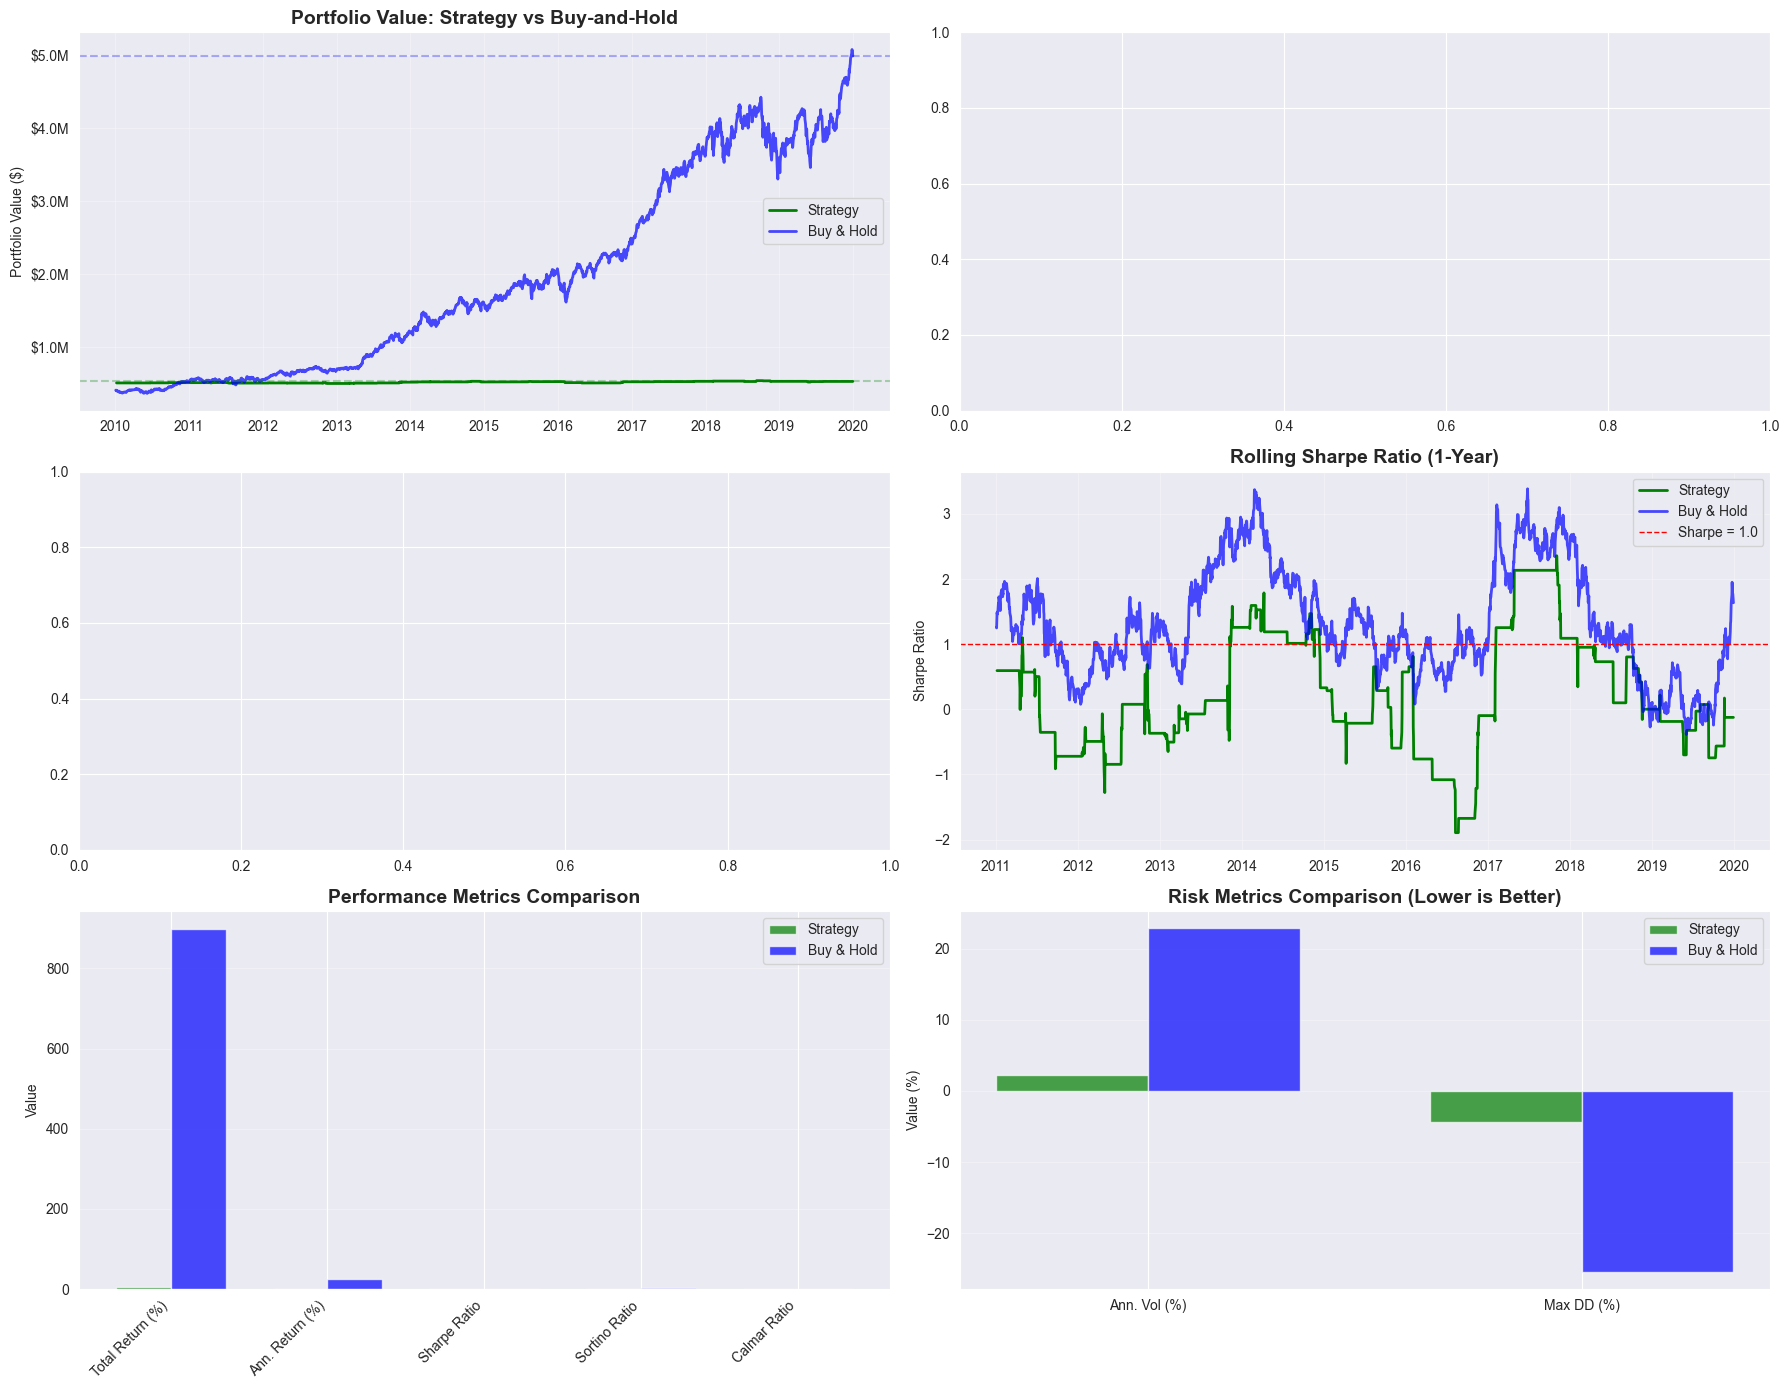


STRATEGY VS BUY-AND-HOLD COMPARISON
Period: 2010-01-01 to 2019-12-31

                       Strategy  Buy & Hold   Difference
Total Return              4.10%     898.28%      -894.17
Annualized Return         0.40%      25.93%       -25.52
Annualized Volatility     2.24%      22.87%       -20.63
Sharpe Ratio               0.18        1.13        -0.95
Sortino Ratio              0.06        1.62        -1.56
Max Drawdown             -4.43%     -25.41%       +20.98
Calmar Ratio               0.09        1.02        -0.93
Final Value            $520,520  $4,991,386  $-4,470,866

WINNER DETERMINATION
❌ Buy & Hold has HIGHER total return
❌ Buy & Hold has BETTER risk-adjusted returns (Sharpe)
✅ Strategy has LOWER maximum drawdown
✅ Strategy has LOWER volatility

🤝 TIE: 2 vs 2
⚖️  Both strategies perform equally



In [101]:
# ============================================================================
# RUN STRATEGY VS BUY-AND-HOLD COMPARISON
# ============================================================================

# Assuming you have already run your strategy backtest and stored results in 'results'
# If not, run your backtest first:
# results = run_backtest(start_date=start_date, end_date=end_date, stock_list=stock_list, **other_variables)

# Calculate Buy-and-Hold benchmark
bh_results = calculate_buy_and_hold(
    stock_list=stock_list,
    start_date=start_date,
    end_date=end_date,
    initial_capital=other_variables['initial_capital']
)

# Compare Strategy vs Buy-and-Hold
compare_strategy_vs_benchmark(
    strategy_metrics=results['metrics'],
    bh_metrics=bh_results,
    start_date=start_date,
    end_date=end_date
)

In [102]:
#add monte carlo
# ============================================================================
# MONTE CARLO SIMULATION: PARAMETER UNCERTAINTY
# ============================================================================

def monte_carlo_parameter_test(stock_data: Dict[str, pd.DataFrame], vix_data: pd.DataFrame,
                               base_config: StrategyConfig,
                               n_simulations: int = 500) -> pd.DataFrame:
    """
    Test strategy with random parameter variations
    
    Randomly samples parameters from reasonable ranges to test robustness
    """
    print(f"\n{'='*60}")
    print(f"MONTE CARLO: PARAMETER UNCERTAINTY TEST ({n_simulations} runs)")
    print(f"{'='*60}\n")
    
    # Define parameter ranges
    param_ranges = {
        'ema_fast': list(range(10, 31, 5)),           # [10, 15, 20, 25, 30]
        'ema_slow': list(range(30, 71, 10)),          # [30, 40, 50, 60, 70]
        'rsi_period': list(range(10, 21, 2)),         # [10, 12, 14, 16, 18, 20]
        'adx_threshold': np.arange(15, 36, 5),        # [15, 20, 25, 30, 35]
        # 'rsi_long_threshold': np.arange(45, 61, 5),   # [45, 50, 55, 60]
        'stop_loss_pct': np.arange(0.015, 0.031, 0.005),     # [1.5%, 2%, 2.5%, 3%]
        'trailing_stop_pct': np.arange(0.01, 0.026, 0.005),  # [1%, 1.5%, 2%, 2.5%]
        'max_positions': list(range(5, 16, 5))        # [5, 10, 15]
    }
    
    results = []
    failed_count = 0
    
    for i in tqdm(range(n_simulations), desc="Running parameter variations"):
        # Random parameter selection
        test_config = StrategyConfig(
            ema_fast=np.random.choice(param_ranges['ema_fast']),
            ema_slow=np.random.choice(param_ranges['ema_slow']),
            rsi_period=np.random.choice(param_ranges['rsi_period']),
            adx_threshold=np.random.choice(param_ranges['adx_threshold']),
            # rsi_long_threshold=np.random.choice(param_ranges['rsi_long_threshold']),
            stop_loss_pct=np.random.choice(param_ranges['stop_loss_pct']),
            trailing_stop_pct=np.random.choice(param_ranges['trailing_stop_pct']),
            max_positions=np.random.choice(param_ranges['max_positions']),
            initial_capital=base_config.initial_capital,
            transaction_cost=base_config.transaction_cost,
            leverage=base_config.leverage,
            train_start=base_config.train_start,
            train_end=base_config.train_end
        )
        
        # Ensure fast < slow
        if test_config.ema_fast >= test_config.ema_slow:
            failed_count += 1
            continue
        
        try:
            # Run backtest with new parameters
            backtester = PortfolioBacktester(test_config, stock_data, vix_data)
            backtester.run()
            
            metrics = calculate_portfolio_metrics(backtester)
            # --- FIX: Access metrics from the 'overall' sub-dictionary ---
            if 'overall' not in metrics:
                failed_count += 1
                continue
            n = metrics['overall']
            
            results.append({
                'run': i,
                'ema_fast': test_config.ema_fast,
                'ema_slow': test_config.ema_slow,
                'adx_threshold': test_config.adx_threshold,
                'stop_loss_pct': test_config.stop_loss_pct,
                'max_positions': test_config.max_positions,
                'total_return': n['total_return'],
                'annualized_return': n['annualized_return'],
                'sharpe_ratio': n['sharpe_ratio'],
                'sortino_ratio': n['sortino_ratio'],
                'max_drawdown': n['max_drawdown'],
                'calmar_ratio': n['calmar_ratio'],
                'win_rate': n['win_rate'],
                'total_trades': n['total_trades']
            })
            
        except Exception as e:
            failed_count += 1
            continue
    
    results_df = pd.DataFrame(results)
    
    print(f"\n✅ Completed: {len(results_df)} successful, {failed_count} failed")
    print(f"\nParameter Uncertainty Results:")
    print(f"  Mean Sharpe Ratio: {results_df['sharpe_ratio'].mean():.2f}")
    print(f"  Median Sharpe Ratio: {results_df['sharpe_ratio'].median():.2f}")
    print(f"  Std Dev Sharpe Ratio: {results_df['sharpe_ratio'].std():.2f}")
    print(f"  % Profitable Runs: {(results_df['total_return'] > 0).sum() / len(results_df) * 100:.1f}%")
    print(f"  % Sharpe > 1.0: {(results_df['sharpe_ratio'] > 1.0).sum() / len(results_df) * 100:.1f}%")
    
    return results_df

print("✅ Monte Carlo parameter test function defined!")

✅ Monte Carlo parameter test function defined!


In [103]:
# ============================================================================
# MONTE CARLO SIMULATION: BOOTSTRAP RESAMPLING
# ============================================================================

def monte_carlo_bootstrap_test(strategy_results: pd.DataFrame,
                               n_samples: int = 1000) -> pd.DataFrame:
    """
    Bootstrap resampling of daily returns to test statistical significance
    
    Resamples with replacement to generate confidence intervals
    """
    print(f"\n{'='*60}")
    print(f"MONTE CARLO: BOOTSTRAP RESAMPLING ({n_samples} samples)")
    print(f"{'='*60}\n")
    
    # Get strategy returns
    daily_returns = strategy_results['daily_return'].dropna()
    n_days = len(daily_returns)
    
    if n_days < 10:
        print("⚠️ Insufficient data for bootstrap")
        return pd.DataFrame()
    
    bootstrap_results = []
    
    for i in tqdm(range(n_samples), desc="Bootstrap resampling"):
        # Resample with replacement
        resampled_returns = np.random.choice(daily_returns, size=n_days, replace=True)
        
        # Calculate metrics
        total_return = np.exp(resampled_returns.sum()) - 1
        annual_return = (1 + total_return) ** (252 / n_days) - 1
        annual_vol = resampled_returns.std() * np.sqrt(252)
        sharpe = annual_return / annual_vol if annual_vol > 0 else 0
        
        # Downside deviation
        downside = resampled_returns[resampled_returns < 0]
        downside_std = downside.std() * np.sqrt(252) if len(downside) > 0 else 0.0001
        sortino = annual_return / downside_std if downside_std > 0 else 0
        
        bootstrap_results.append({
            'sample': i,
            'total_return': total_return,
            'annualized_return': annual_return,
            'annualized_volatility': annual_vol,
            'sharpe_ratio': sharpe,
            'sortino_ratio': sortino
        })
    
    bootstrap_df = pd.DataFrame(bootstrap_results)
    
    print(f"\n✅ Bootstrap Resampling Results:")
    print(f"  Mean Return: {bootstrap_df['annualized_return'].mean()*100:.2f}%")
    print(f"  95% CI Return: [{bootstrap_df['annualized_return'].quantile(0.025)*100:.2f}%, "
          f"{bootstrap_df['annualized_return'].quantile(0.975)*100:.2f}%]")
    print(f"  Mean Sharpe: {bootstrap_df['sharpe_ratio'].mean():.2f}")
    print(f"  95% CI Sharpe: [{bootstrap_df['sharpe_ratio'].quantile(0.025):.2f}, "
          f"{bootstrap_df['sharpe_ratio'].quantile(0.975):.2f}]")
    print(f"  Probability of Positive Return: {(bootstrap_df['annualized_return'] > 0).sum() / len(bootstrap_df) * 100:.1f}%")
    
    return bootstrap_df

print("✅ Monte Carlo bootstrap function defined!")

✅ Monte Carlo bootstrap function defined!


In [104]:
# ============================================================================
# MONTE CARLO SIMULATION: SYNTHETIC PRICE PATHS
# ============================================================================

def monte_carlo_synthetic_paths(stock_data: Dict[str, pd.DataFrame], # <-- ADDED
                                vix_data: pd.DataFrame,           # <-- ADDED
                                base_config: StrategyConfig,
                                n_paths: int = 100) -> pd.DataFrame:
    """
    Test strategy on synthetic price paths using Geometric Brownian Motion
    
    Generates random price paths with same statistical properties as real data
    """
    print(f"\n{'='*60}")
    print(f"MONTE CARLO: SYNTHETIC PRICE PATHS ({n_paths} paths)")
    print(f"{'='*60}\n")
    
    # Get trading dates and number of days from VIX data
    trading_dates = vix_data.index
    n_days = len(trading_dates)

    print("Estimating parameters from existing data...")
    stock_params = {}
    for symbol, df in stock_data.items():
        # Ensure df index matches vix index
        df = df.reindex(trading_dates).fillna(method='ffill')
        if df.isnull().any().any():
            continue # Skip if still has NaNs
            
        returns = np.log(df['Close'] / df['Close'].shift(1)).dropna()
        if returns.empty:
            continue
            
        stock_params[symbol] = {
            'mu': returns.mean(),
            'sigma': returns.std(),
            'initial_price': df['Close'].iloc[0],
        }
    
    if len(stock_params) == 0:
        print("⚠️ No valid stock data to estimate parameters")
        return pd.DataFrame()

    print(f"Generating paths for {len(stock_params)} stocks...")
    
    # Run simulations
    synthetic_results = []
    failed_count = 0
    
    for path_num in tqdm(range(n_paths), desc="Generating synthetic paths"):
        # Generate synthetic data for each stock
        synthetic_stock_data = {}
        
        for symbol, params in stock_params.items():
            # Geometric Brownian Motion
            dt = 1/252 # Assuming 252 trading days
            price_path = [params['initial_price']]
            
            for _ in range(n_days - 1):
                drift = (params['mu'] - 0.5 * params['sigma']**2) * dt
                diffusion = params['sigma'] * np.sqrt(dt) * np.random.normal()
                price = price_path[-1] * np.exp(drift + diffusion)
                price_path.append(price)
            
            # Create synthetic dataframe
            synthetic_df = pd.DataFrame({
                'Close': price_path,
                # Add High/Low/Volume for indicators
                'High': [p * (1 + abs(np.random.normal(0, 0.01))) for p in price_path],
                'Low': [p * (1 - abs(np.random.normal(0, 0.01))) for p in price_path],
                'Volume': [np.random.randint(1e6, 1e7) for _ in price_path]
            }, index=trading_dates) # <-- Use VIX index
            
            # Calculate indicators
            try:
                df_with_indicators = calculate_indicators(synthetic_df, base_config)
                synthetic_stock_data[symbol] = df_with_indicators
            except:
                continue
        
        if len(synthetic_stock_data) < 1:
            failed_count += 1
            continue
        
        # Run backtest on synthetic data
        try:
            # --- FIX: Pass 'vix_data' to the backtester ---
            backtester = PortfolioBacktester(base_config, synthetic_stock_data, vix_data) # <-- ADDED
            backtester.run()
            
            metrics = calculate_portfolio_metrics(backtester)
            
            # --- FIX: Access metrics from the 'overall' sub-dictionary ---
            if 'overall' not in metrics:
                failed_count += 1
                continue
            
            m = metrics['overall'] # Helper variable
            
            synthetic_results.append({
                'path': path_num,
                'total_return': m['total_return'],           # <-- FIXED
                'annualized_return': m['annualized_return'], # <-- FIXED
                'sharpe_ratio': m['sharpe_ratio'],           # <-- FIXED
                'sortino_ratio': m['sortino_ratio'],         # <-- FIXED
                'max_drawdown': m['max_drawdown'],         # <-- FIXED
                'calmar_ratio': m['calmar_ratio'],           # <-- FIXED
                'total_trades': m['total_trades']          # <-- FIXED
            })
            
        except Exception as e:
            failed_count += 1
            continue
    
    synthetic_df = pd.DataFrame(synthetic_results)

    
    if len(synthetic_df) > 0:
        print(f"\n✅ Completed: {len(synthetic_df)} successful, {failed_count} failed")
        print(f"\nSynthetic Paths Results:")
        print(f"  Mean Sharpe Ratio: {synthetic_df['sharpe_ratio'].mean():.2f}")
        print(f"  % Profitable Runs: {(synthetic_df['total_return'] > 0).sum() / len(synthetic_df) * 100:.1f}%")
        print(f"  % Sharpe > 1.0: {(synthetic_df['sharpe_ratio'] > 1.0).sum() / len(synthetic_df) * 100:.1f}%")
    else:
        print("⚠️ All synthetic simulations failed")
    
    return synthetic_df

print("✅ Monte Carlo synthetic paths function defined!")

✅ Monte Carlo synthetic paths function defined!


In [105]:
# ============================================================================
# MONTE CARLO VISUALIZATION
# ============================================================================

def plot_monte_carlo_results(param_results: pd.DataFrame,
                             bootstrap_results: pd.DataFrame,
                             synthetic_results: pd.DataFrame,
                             actual_sharpe: float):
    """
    Visualize all Monte Carlo simulation results
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Parameter Test - Sharpe Distribution
    if len(param_results) > 0:
        axes[0, 0].hist(param_results['sharpe_ratio'], bins=30, color='blue', alpha=0.7, edgecolor='black')
        axes[0, 0].axvline(param_results['sharpe_ratio'].mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {param_results["sharpe_ratio"].mean():.2f}')
        axes[0, 0].axvline(actual_sharpe, color='green', linestyle='--', 
                          linewidth=2, label=f'Actual: {actual_sharpe:.2f}')
        axes[0, 0].axvline(1.0, color='gray', linestyle=':', linewidth=1, label='Target: 1.0')
        axes[0, 0].set_title('Parameter Uncertainty: Sharpe Ratio', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('Sharpe Ratio')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Parameter Test - Returns Distribution
    if len(param_results) > 0:
        axes[0, 1].hist(param_results['total_return'] * 100, bins=30, color='green', alpha=0.7, edgecolor='black')
        axes[0, 1].axvline(param_results['total_return'].mean() * 100, color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {param_results["total_return"].mean()*100:.1f}%')
        axes[0, 1].axvline(0, color='black', linestyle='-', linewidth=1)
        axes[0, 1].set_title('Parameter Uncertainty: Total Return', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Total Return (%)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Parameter Test - Max Drawdown
    if len(param_results) > 0:
        axes[0, 2].hist(param_results['max_drawdown'] * 100, bins=30, color='red', alpha=0.7, edgecolor='black')
        axes[0, 2].axvline(param_results['max_drawdown'].mean() * 100, color='blue', linestyle='--', 
                          linewidth=2, label=f'Mean: {param_results["max_drawdown"].mean()*100:.1f}%')
        axes[0, 2].axvline(-15, color='darkred', linestyle=':', linewidth=2, label='Kill Switch: -15%')
        axes[0, 2].set_title('Parameter Uncertainty: Max Drawdown', fontsize=12, fontweight='bold')
        axes[0, 2].set_xlabel('Max Drawdown (%)')
        axes[0, 2].set_ylabel('Frequency')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Bootstrap - Sharpe Distribution
    if len(bootstrap_results) > 0:
        axes[1, 0].hist(bootstrap_results['sharpe_ratio'], bins=30, color='purple', alpha=0.7, edgecolor='black')
        axes[1, 0].axvline(bootstrap_results['sharpe_ratio'].mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {bootstrap_results["sharpe_ratio"].mean():.2f}')
        ci_lower = bootstrap_results['sharpe_ratio'].quantile(0.025)
        ci_upper = bootstrap_results['sharpe_ratio'].quantile(0.975)
        axes[1, 0].axvline(ci_lower, color='orange', linestyle=':', linewidth=1, label=f'95% CI')
        axes[1, 0].axvline(ci_upper, color='orange', linestyle=':', linewidth=1)
        axes[1, 0].set_title('Bootstrap: Sharpe Ratio Distribution', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Sharpe Ratio')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Bootstrap - Return Distribution
    if len(bootstrap_results) > 0:
        axes[1, 1].hist(bootstrap_results['annualized_return'] * 100, bins=30, color='cyan', alpha=0.7, edgecolor='black')
        axes[1, 1].axvline(bootstrap_results['annualized_return'].mean() * 100, color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {bootstrap_results["annualized_return"].mean()*100:.1f}%')
        axes[1, 1].axvline(0, color='black', linestyle='-', linewidth=1)
        axes[1, 1].set_title('Bootstrap: Annualized Return', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Annualized Return (%)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Synthetic Paths - Sharpe Distribution
    if len(synthetic_results) > 0:
        axes[1, 2].hist(synthetic_results['sharpe_ratio'], bins=30, color='orange', alpha=0.7, edgecolor='black')
        axes[1, 2].axvline(synthetic_results['sharpe_ratio'].mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {synthetic_results["sharpe_ratio"].mean():.2f}')
        axes[1, 2].axvline(actual_sharpe, color='green', linestyle='--', 
                          linewidth=2, label=f'Actual: {actual_sharpe:.2f}')
        axes[1, 2].set_title('Synthetic Paths: Sharpe Ratio', fontsize=12, fontweight='bold')
        axes[1, 2].set_xlabel('Sharpe Ratio')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n{'='*80}")
    print("MONTE CARLO SUMMARY")
    print(f"{'='*80}\n")
    
    if len(param_results) > 0:
        print("Parameter Uncertainty Test:")
        print(f"  Simulations: {len(param_results)}")
        print(f"  Mean Sharpe: {param_results['sharpe_ratio'].mean():.2f} ± {param_results['sharpe_ratio'].std():.2f}")
        print(f"  Sharpe Range: [{param_results['sharpe_ratio'].min():.2f}, {param_results['sharpe_ratio'].max():.2f}]")
        print(f"  % Sharpe > Actual ({actual_sharpe:.2f}): {(param_results['sharpe_ratio'] > actual_sharpe).sum() / len(param_results) * 100:.1f}%")
        print()
    
    if len(bootstrap_results) > 0:
        print("Bootstrap Resampling:")
        print(f"  Samples: {len(bootstrap_results)}")
        print(f"  Mean Return: {bootstrap_results['annualized_return'].mean()*100:.2f}%")
        print(f"  95% CI: [{bootstrap_results['annualized_return'].quantile(0.025)*100:.2f}%, {bootstrap_results['annualized_return'].quantile(0.975)*100:.2f}%]")
        print(f"  P(Return > 0): {(bootstrap_results['annualized_return'] > 0).sum() / len(bootstrap_results) * 100:.1f}%")
        print()
    
    if len(synthetic_results) > 0:
        print("Synthetic Price Paths:")
        print(f"  Paths: {len(synthetic_results)}")
        print(f"  Mean Sharpe: {synthetic_results['sharpe_ratio'].mean():.2f}")
        print(f"  % Profitable: {(synthetic_results['total_return'] > 0).sum() / len(synthetic_results) * 100:.1f}%")
        print(f"  Strategy works on random data: {'✅ YES' if synthetic_results['sharpe_ratio'].mean() > 0 else '❌ NO'}")
    
    print(f"\n{'='*80}\n")

print("✅ Monte Carlo visualization function defined!")

✅ Monte Carlo visualization function defined!


✅ All variables extracted successfully
   Config: <class '__main__.StrategyConfig'>
   Stock data: 10 stocks
   VIX data: 2511 days
   Strategy Sharpe: 0.18

STARTING QUICK MONTE CARLO ANALYSIS (10 simulations each)

Test 1/3: Parameter Uncertainty (10 simulations)...

MONTE CARLO: PARAMETER UNCERTAINTY TEST (10 runs)



Running parameter variations:   0%|          | 0/10 [00:00<?, ?it/s]


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2511 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 8733
Total Trades: 60
Final Portfolio Value: $555,136.01
Total Return: 11.03%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2511 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 8249
Total Trades: 43
Final Portfolio Value: $586,472.96
Total Return: 17.29%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2511 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 8249
Total Trades: 43
Final Portfolio Value: $566,871.81
Total Return: 13.37%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2511 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 8463
Total Trades: 72
Final Portfolio Value: $636,731.45
Total Return: 27.35%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2511 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 8733
Total Trades: 60
Final Portfolio Value: $603,934.30
Total Return: 20.79%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2511 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 8463
Total Trades: 72
Final Portfolio Value: $568,404.43
Total Return: 13.68%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2511 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 8733
Total Trades: 60
Final Portfolio Value: $603,934.30
Total Return: 20.79%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2511 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 8652
Total Trades: 50
Final Portfolio Value: $524,290.20
Total Return: 4.86%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2511 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 8733
Total Trades: 60
Final Portfolio Value: $603,934.30
Total Return: 20.79%


EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2019-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2511 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 8249
Total Trades: 43
Final Portfolio Value: $584,372.31
Total Return: 16.87%


✅ Completed: 10 successful, 0 failed

Parameter Uncertainty Results:
  Mean Sharpe Ratio: 0.58
  Median Sharpe Ratio: 0.66
  Std Dev Sharpe Ratio: 0.17
  % Profitable Runs: 100.0%
  % Sharpe > 1.0: 0.0%
✅ Parameter test complete: 10 successful runs

Test 2/3: Bootstrap Resampling (10 samples)...

MONTE CARLO: BOOTSTRAP RESAMPLING (10 samples)



Bootstrap resampling:   0%|          | 0/10 [00:00<?, ?it/s]


✅ Bootstrap Resampling Results:
  Mean Return: 0.75%
  95% CI Return: [-0.03%, 1.58%]
  Mean Sharpe: 0.31
  95% CI Sharpe: [-0.01, 0.58]
  Probability of Positive Return: 90.0%
✅ Bootstrap test complete: 10 samples

Test 3/3: Synthetic Price Paths (10 paths)...

MONTE CARLO: SYNTHETIC PRICE PATHS (10 paths)

Estimating parameters from existing data...
⚠️ No valid stock data to estimate parameters
✅ Synthetic test complete: 0 paths

Generating visualizations...


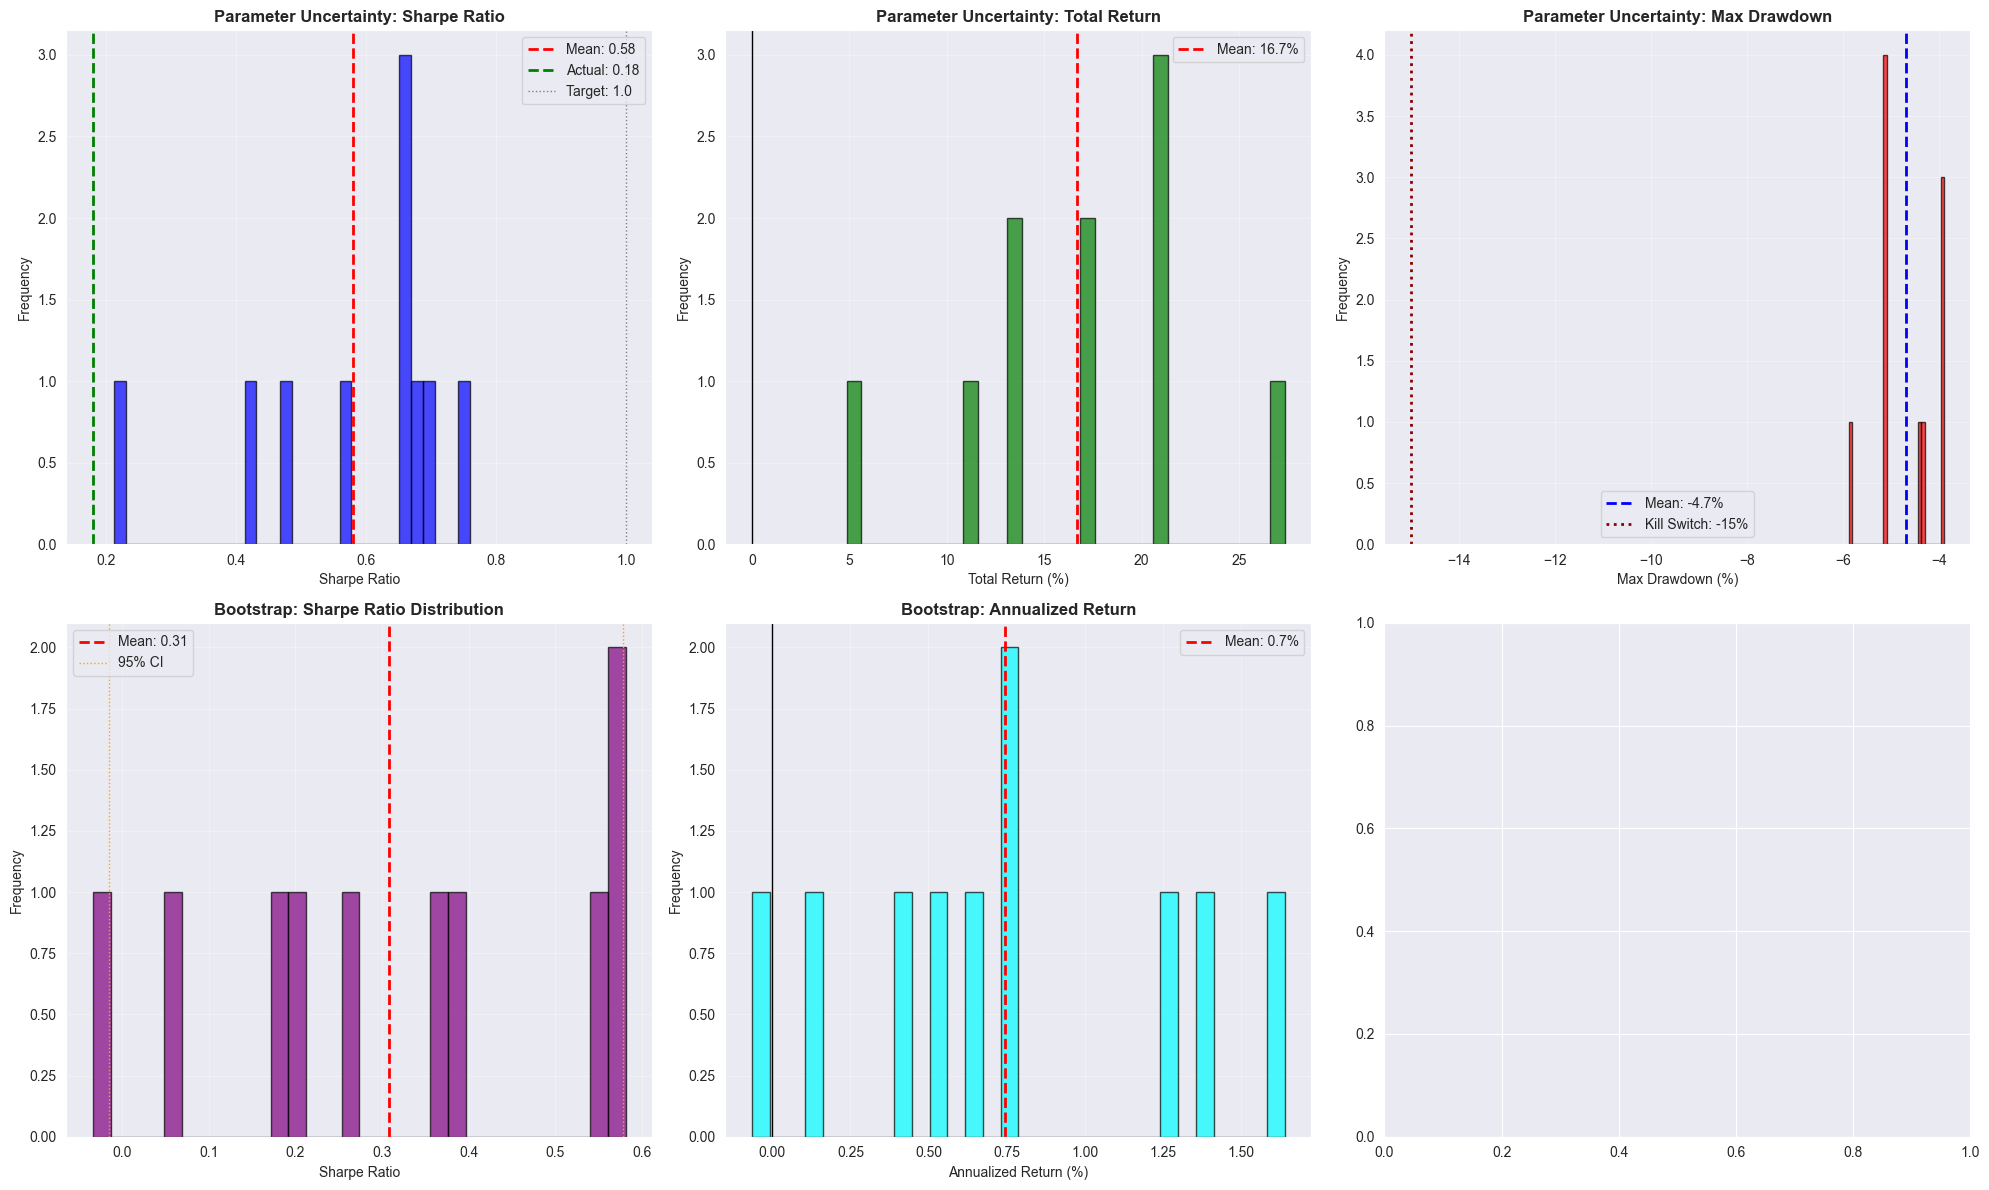


MONTE CARLO SUMMARY

Parameter Uncertainty Test:
  Simulations: 10
  Mean Sharpe: 0.58 ± 0.17
  Sharpe Range: [0.21, 0.76]
  % Sharpe > Actual (0.18): 100.0%

Bootstrap Resampling:
  Samples: 10
  Mean Return: 0.75%
  95% CI: [-0.03%, 1.58%]
  P(Return > 0): 90.0%



✅ Visualizations complete!

QUICK MONTE CARLO RESULTS

Parameter Test (n=10):
  Mean Sharpe: 0.58
  Range: [0.21, 0.76]
  % Profitable: 100%

Bootstrap Test (n=10):
  Mean Return: 0.7%
  Sharpe Range: [-0.03, 0.58]




In [106]:
# ============================================================================
# QUICK MONTE CARLO ANALYSIS (10 SIMULATIONS FOR TESTING)
# ============================================================================

# Step 1: Verify results exist
if 'results' not in locals() and 'results' not in globals():
    raise ValueError("❌ Please run the backtest first: results = run_backtest(...)")

# Step 2: Extract required variables
try:
    config = results['config']
    backtester = results['backtester']
    stock_data = backtester.stock_data
    vix_data = backtester.vix_data # <--- ADD THIS
    strategy_metrics = results['metrics']
    
    print("✅ All variables extracted successfully")
    print(f"   Config: {type(config)}")
    print(f"   Stock data: {len(stock_data)} stocks")
    print(f"   VIX data: {len(vix_data)} days") # <--- ADD THIS
    # --- FIX: Access 'overall' dictionary ---
    print(f"   Strategy Sharpe: {strategy_metrics['overall']['sharpe_ratio']:.2f}")
    
except KeyError as e:
    raise ValueError(f"❌ Missing key in results: {e}. Did you fix the 'overall' nesting?")

# Step 3: Run Monte Carlo Tests with SMALL sample sizes
print(f"\n{'='*60}")
print("STARTING QUICK MONTE CARLO ANALYSIS (10 simulations each)")
print(f"{'='*60}\n")

# Test 1: Parameter Uncertainty (10 runs)
try:
    print("Test 1/3: Parameter Uncertainty (10 simulations)...")
    param_results = monte_carlo_parameter_test(
        stock_data=stock_data,
        vix_data=vix_data, # <--- ADD THIS
        base_config=config,
        n_simulations=10
    )
    print(f"✅ Parameter test complete: {len(param_results)} successful runs")
except Exception as e:
    print(f"❌ Parameter test failed: {e}")
    param_results = pd.DataFrame()

# Test 2: Bootstrap Resampling (10 samples)
# (This function is correct, no changes needed)
try:
    print("\nTest 2/3: Bootstrap Resampling (10 samples)...")
    bootstrap_results = monte_carlo_bootstrap_test(
        strategy_results=strategy_metrics['daily_data'],
        n_samples=10 
    )
    print(f"✅ Bootstrap test complete: {len(bootstrap_results)} samples")
except Exception as e:
    print(f"❌ Bootstrap test failed: {e}")
    bootstrap_results = pd.DataFrame()

# Test 3: Synthetic Paths (10 paths)
try:
    print("\nTest 3/3: Synthetic Price Paths (10 paths)...")
    # --- FIX: Updated function signature ---
    synthetic_results = monte_carlo_synthetic_paths(
        stock_data=stock_data, # <--- ADD THIS
        vix_data=vix_data,   # <--- ADD THIS
        base_config=config,
        n_paths=10
    )
    print(f"✅ Synthetic test complete: {len(synthetic_results)} paths")
except Exception as e:
    print(f"❌ Synthetic test failed: {e}")
    synthetic_results = pd.DataFrame()

# Step 4: Visualize Results
if len(param_results) > 0 or len(bootstrap_results) > 0 or len(synthetic_results) > 0:
    print("\nGenerating visualizations...")
    plot_monte_carlo_results(
        param_results=param_results,
        bootstrap_results=bootstrap_results,
        synthetic_results=synthetic_results,
        # --- FIX: Access 'overall' dictionary ---
        actual_sharpe=strategy_metrics['overall']['sharpe_ratio'] 
    )
    print("✅ Visualizations complete!")
else:
    print("⚠️ No results to visualize")

# Print quick summary
print(f"\n{'='*60}")
print("QUICK MONTE CARLO RESULTS")
print(f"{'='*60}")

if len(param_results) > 0:
    print(f"\nParameter Test (n={len(param_results)}):")
    print(f"  Mean Sharpe: {param_results['sharpe_ratio'].mean():.2f}")
    print(f"  Range: [{param_results['sharpe_ratio'].min():.2f}, {param_results['sharpe_ratio'].max():.2f}]")
    print(f"  % Profitable: {(param_results['total_return'] > 0).sum() / len(param_results) * 100:.0f}%")

if len(bootstrap_results) > 0:
    print(f"\nBootstrap Test (n={len(bootstrap_results)}):")
    print(f"  Mean Return: {bootstrap_results['annualized_return'].mean()*100:.1f}%")
    print(f"  Sharpe Range: [{bootstrap_results['sharpe_ratio'].min():.2f}, {bootstrap_results['sharpe_ratio'].max():.2f}]")

if len(synthetic_results) > 0:
    print(f"\nSynthetic Test (n={len(synthetic_results)}):")
    print(f"  Mean Sharpe: {synthetic_results['sharpe_ratio'].mean():.2f}")
    print(f"  % Profitable: {(synthetic_results['total_return'] > 0).sum() / len(synthetic_results) * 100:.0f}%")

print(f"\n{'='*60}\n")